In [1]:

import pandas as pd
import numpy as np
import folium
import pylab
import re
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import skopt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space  import Real, Categorical, Integer
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
# per accedere ai dati dal file CSV, è necessaria una funzione read_csv() che recuperi i dati sotto forma di Dataframe.
df = pd.read_csv("Police_Department_Incidents_-_Previous_Year__2016_.csv")
df

IncidntNum        Category  \
0        120058272     WEAPON LAWS   
1        120058272     WEAPON LAWS   
2        141059263        WARRANTS   
3        160013662    NON-CRIMINAL   
4        160002740    NON-CRIMINAL   
...            ...             ...   
150495   161061000         ASSAULT   
150496   176000742    NON-CRIMINAL   
150497   176000758   LARCENY/THEFT   
150498   176000764   LARCENY/THEFT   
150499   179002868  OTHER OFFENSES   

                                                 Descript DayOfWeek  \
0                               POSS OF PROHIBITED WEAPON    Friday   
1          FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE    Friday   
2                                          WARRANT ARREST    Monday   
3                                           LOST PROPERTY   Tuesday   
4                                           LOST PROPERTY    Friday   
...                                                   ...       ...   
150495                                            BATTERY    Friday   
150496                                      LOST PROPERTY    Friday   
150497                            PETTY THEFT OF PROPERTY  Thursday   
150498                            GRAND THEFT OF PROPERTY    Friday   
150499  FRAUDULENT GAME OR TRICK, OBTAINING MONEY OR P...    Friday   

                          Date   Time  PdDistrict      Resolution  \
0       01/29/2016 12:00:00 AM  11:00    SOUTHERN  ARREST, BOOKED   
1       01/29/2016 12:00:00 AM  11:00    SOUTHERN  ARREST, BOOKED   
2       04/25/2016 12:00:00 AM  14:59     BAYVIEW  ARREST, BOOKED   
3       01/05/2016 12:00:00 AM  23:50  TENDERLOIN            NONE   
4       01/01/2016 12:00:00 AM  00:30     MISSION            NONE   
...                        ...    ...         ...             ...   
150495  12/30/2016 12:00:00 AM  21:01        PARK            NONE   
150496  12/30/2016 12:00:00 AM  08:00     CENTRAL            NONE   
150497  12/29/2016 12:00:00 AM  20:00     CENTRAL            NONE   
150498  12/30/2016 12:00:00 AM  10:00     CENTRAL            NONE   
150499  12/02/2016 12:00:00 AM  14:00    SOUTHERN            NONE   

                         Address           X          Y  \
0         800 Block of BRYANT ST -122.403405  37.775421   
1         800 Block of BRYANT ST -122.403405  37.775421   
2          KEITH ST / SHAFTER AV -122.388856  37.729981   
3         JONES ST / OFARRELL ST -122.412971  37.785788   
4           16TH ST / MISSION ST -122.419672  37.765050   
...                          ...         ...        ...   
150495       OAK ST / STANYAN ST -122.453982  37.771428   
150496   JACKSON ST / SANSOME ST -122.401857  37.796626   
150497       PINE ST / TAYLOR ST -122.412269  37.790673   
150498  200 Block of STOCKTON ST -122.406659  37.788275   
150499    800 Block of BRYANT ST -122.403405  37.775421   

                                     Location            PdId  
0        (37.775420706711, -122.403404791479)  12005827212120  
1        (37.775420706711, -122.403404791479)  12005827212168  
2       (37.7299809672996, -122.388856204292)  14105926363010  
3       (37.7857883766888, -122.412970537591)  16001366271000  
4       (37.7650501214668, -122.419671780296)  16000274071000  
...                                       ...             ...  
150495  (37.7714278595913, -122.453981622365)  16106100004134  
150496  (37.7966261239618, -122.401857374739)  17600074271000  
150497   (37.7906727649886, -122.41226909106)  17600075806372  
150498  (37.7882745285785, -122.406658711008)  17600076406374  
150499   (37.775420706711, -122.403404791479)  17900286809024  

[150500 rows x 13 columns]

In [3]:
# la funzione "info()" viene utilizzata per ottenere un riepilogo conciso del frame di dati.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150500 entries, 0 to 150499
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IncidntNum  150500 non-null  int64  
 1   Category    150500 non-null  object 
 2   Descript    150500 non-null  object 
 3   DayOfWeek   150500 non-null  object 
 4   Date        150500 non-null  object 
 5   Time        150500 non-null  object 
 6   PdDistrict  150499 non-null  object 
 7   Resolution  150500 non-null  object 
 8   Address     150500 non-null  object 
 9   X           150500 non-null  float64
 10  Y           150500 non-null  float64
 11  Location    150500 non-null  object 
 12  PdId        150500 non-null  int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 14.9+ MB


In [4]:
# stampo la somma di NA presenti nel dataframe.
df.isna().sum()

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
dtype: int64

## Cancellazione valore nullo

In [5]:
# Ricerca del valore nullo all'interno della feature PdDistrict 
valore_nullo = df[df['PdDistrict'].isnull()]
valore_nullo

IncidntNum       Category                      Descript DayOfWeek  \
112851   166018573  LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO    Sunday   

                          Date   Time PdDistrict Resolution  \
112851  01/17/2016 12:00:00 AM  23:54        NaN       NONE   

                        Address           X          Y  \
112851  100 Block of VELASCO AV -122.413352  37.708202   

                                     Location            PdId  
112851  (37.7082024584902, -122.413351985284)  16601857306244

In [6]:
# Eliminazione dei valori nulli dalla colonna 'PdDistrict'
df = df.dropna(subset=['PdDistrict'])
df.isna().sum()

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
dtype: int64

In [7]:
df.count()

IncidntNum    150499
Category      150499
Descript      150499
DayOfWeek     150499
Date          150499
Time          150499
PdDistrict    150499
Resolution    150499
Address       150499
X             150499
Y             150499
Location      150499
PdId          150499
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150499 entries, 0 to 150499
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IncidntNum  150499 non-null  int64  
 1   Category    150499 non-null  object 
 2   Descript    150499 non-null  object 
 3   DayOfWeek   150499 non-null  object 
 4   Date        150499 non-null  object 
 5   Time        150499 non-null  object 
 6   PdDistrict  150499 non-null  object 
 7   Resolution  150499 non-null  object 
 8   Address     150499 non-null  object 
 9   X           150499 non-null  float64
 10  Y           150499 non-null  float64
 11  Location    150499 non-null  object 
 12  PdId        150499 non-null  int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 16.1+ MB


## Analisi, Esplorazione e Codifica dei Dati


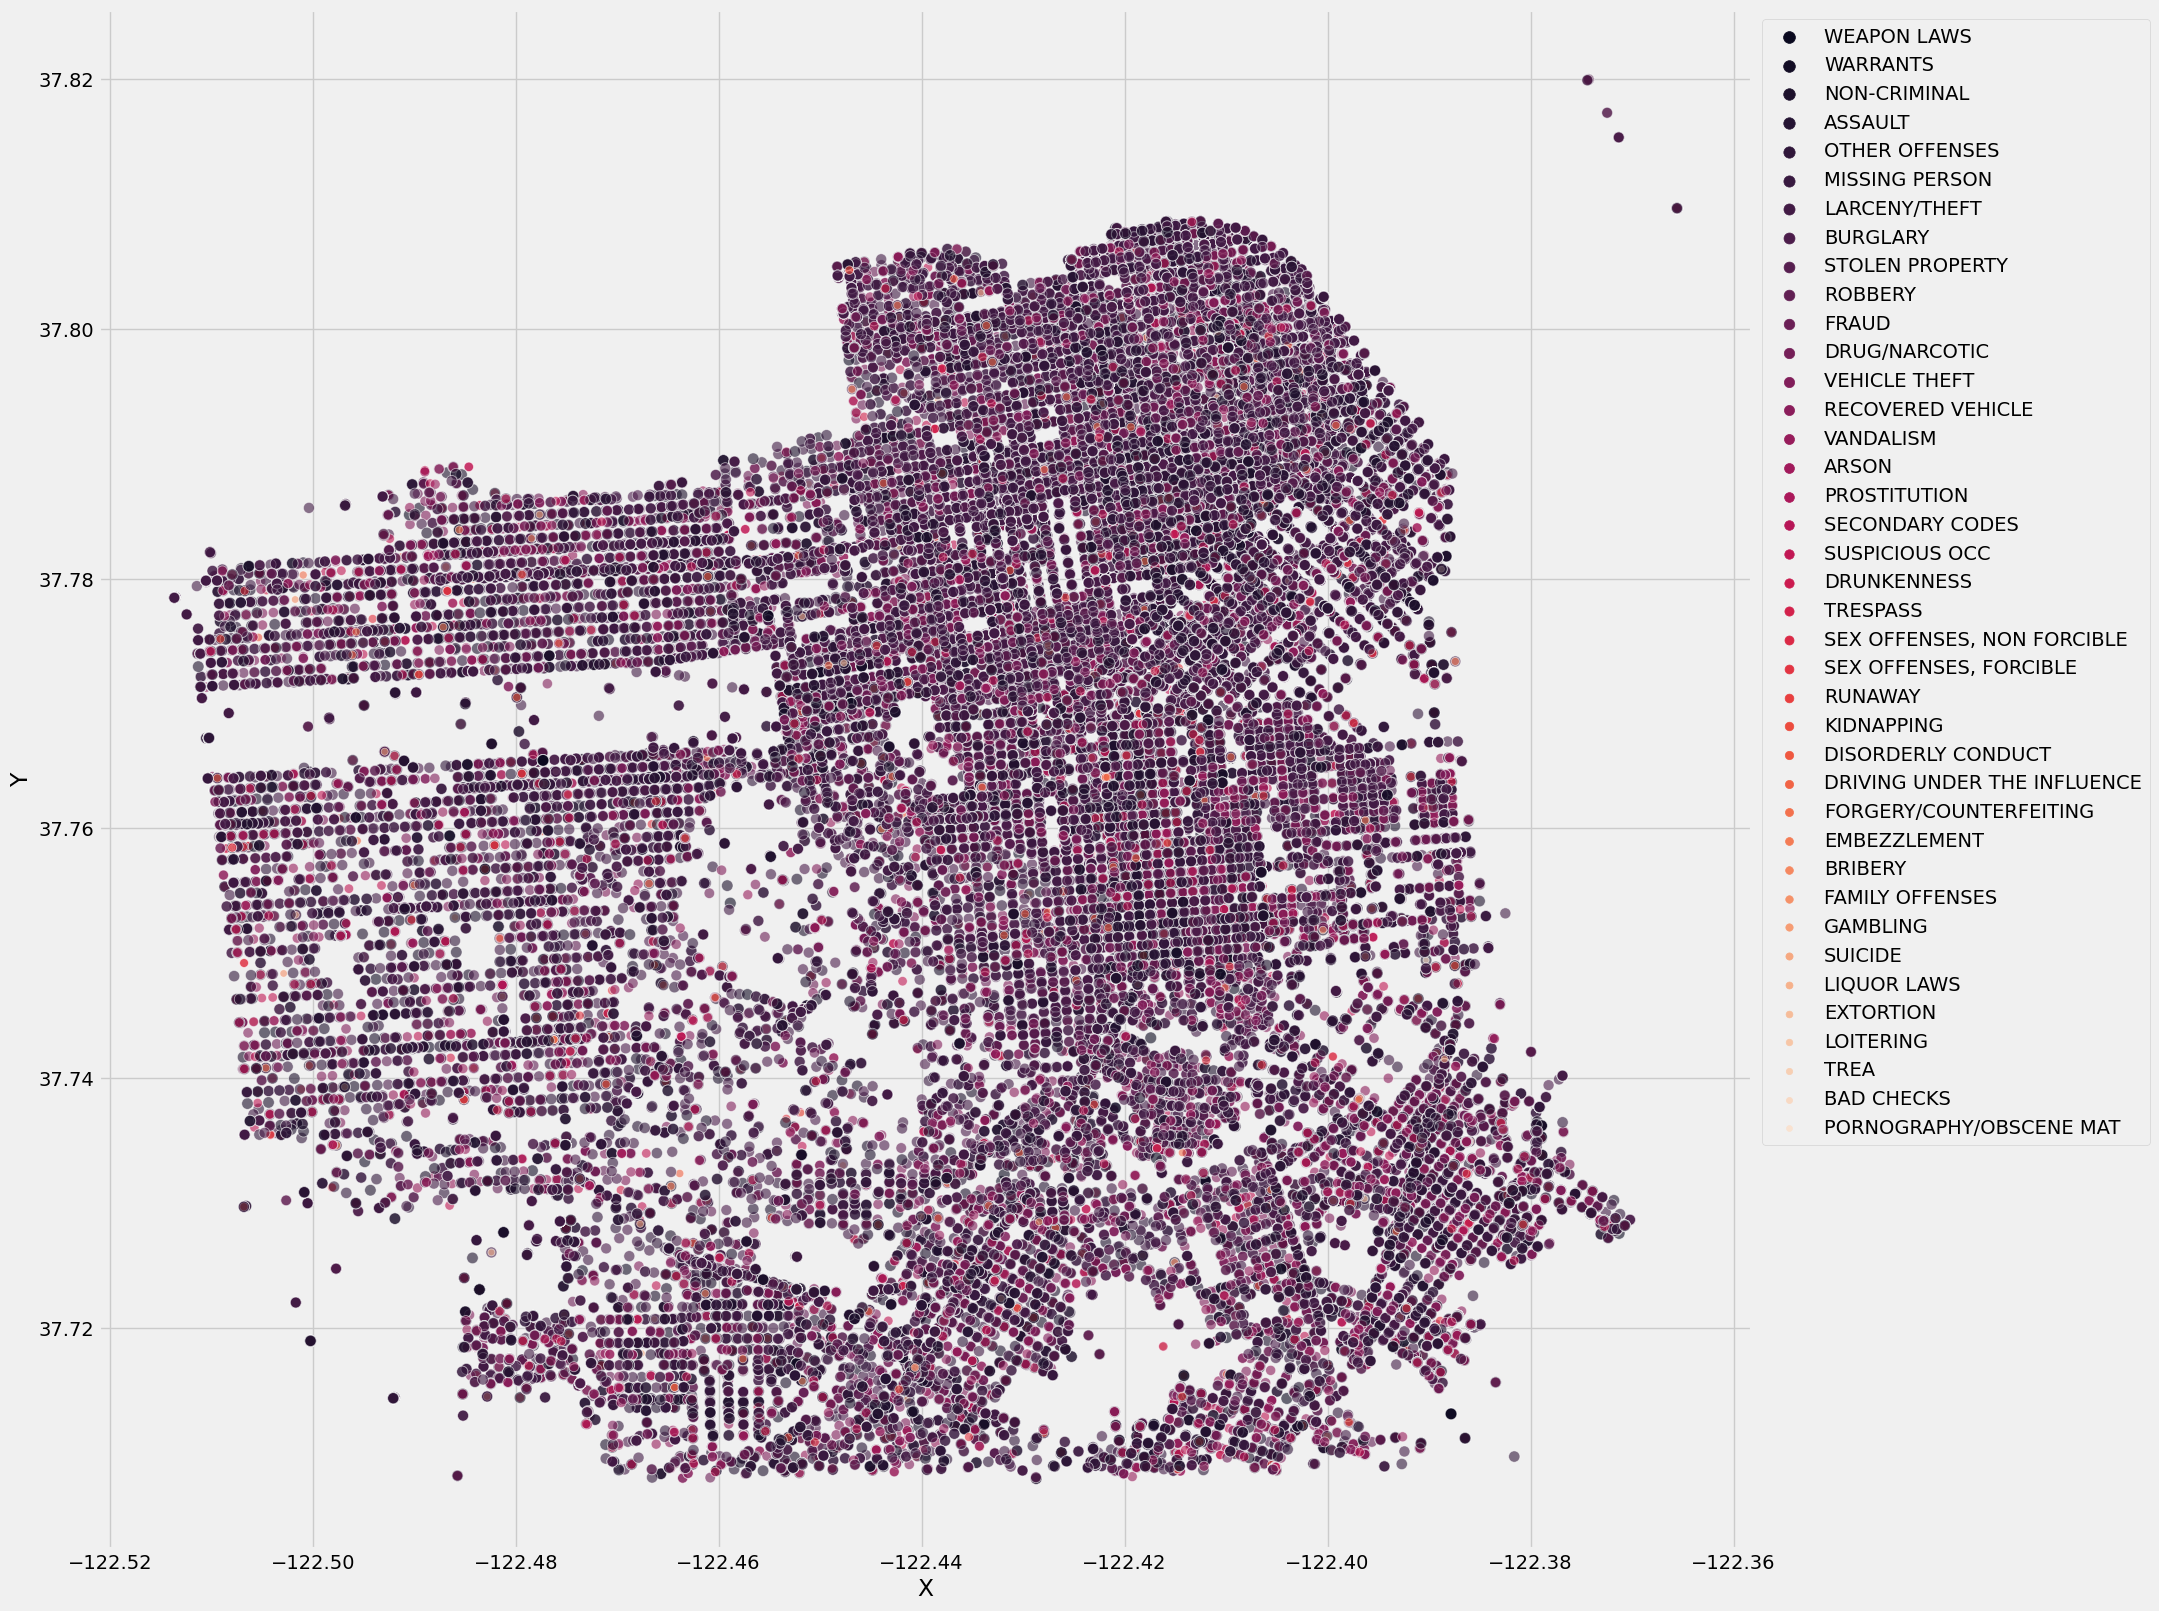

In [10]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize=(19, 19))
    sns.scatterplot(data=df.iloc[:150500], x='X', y='Y', alpha=0.6, palette='rocket', hue='Category', size='Category') 
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.show()

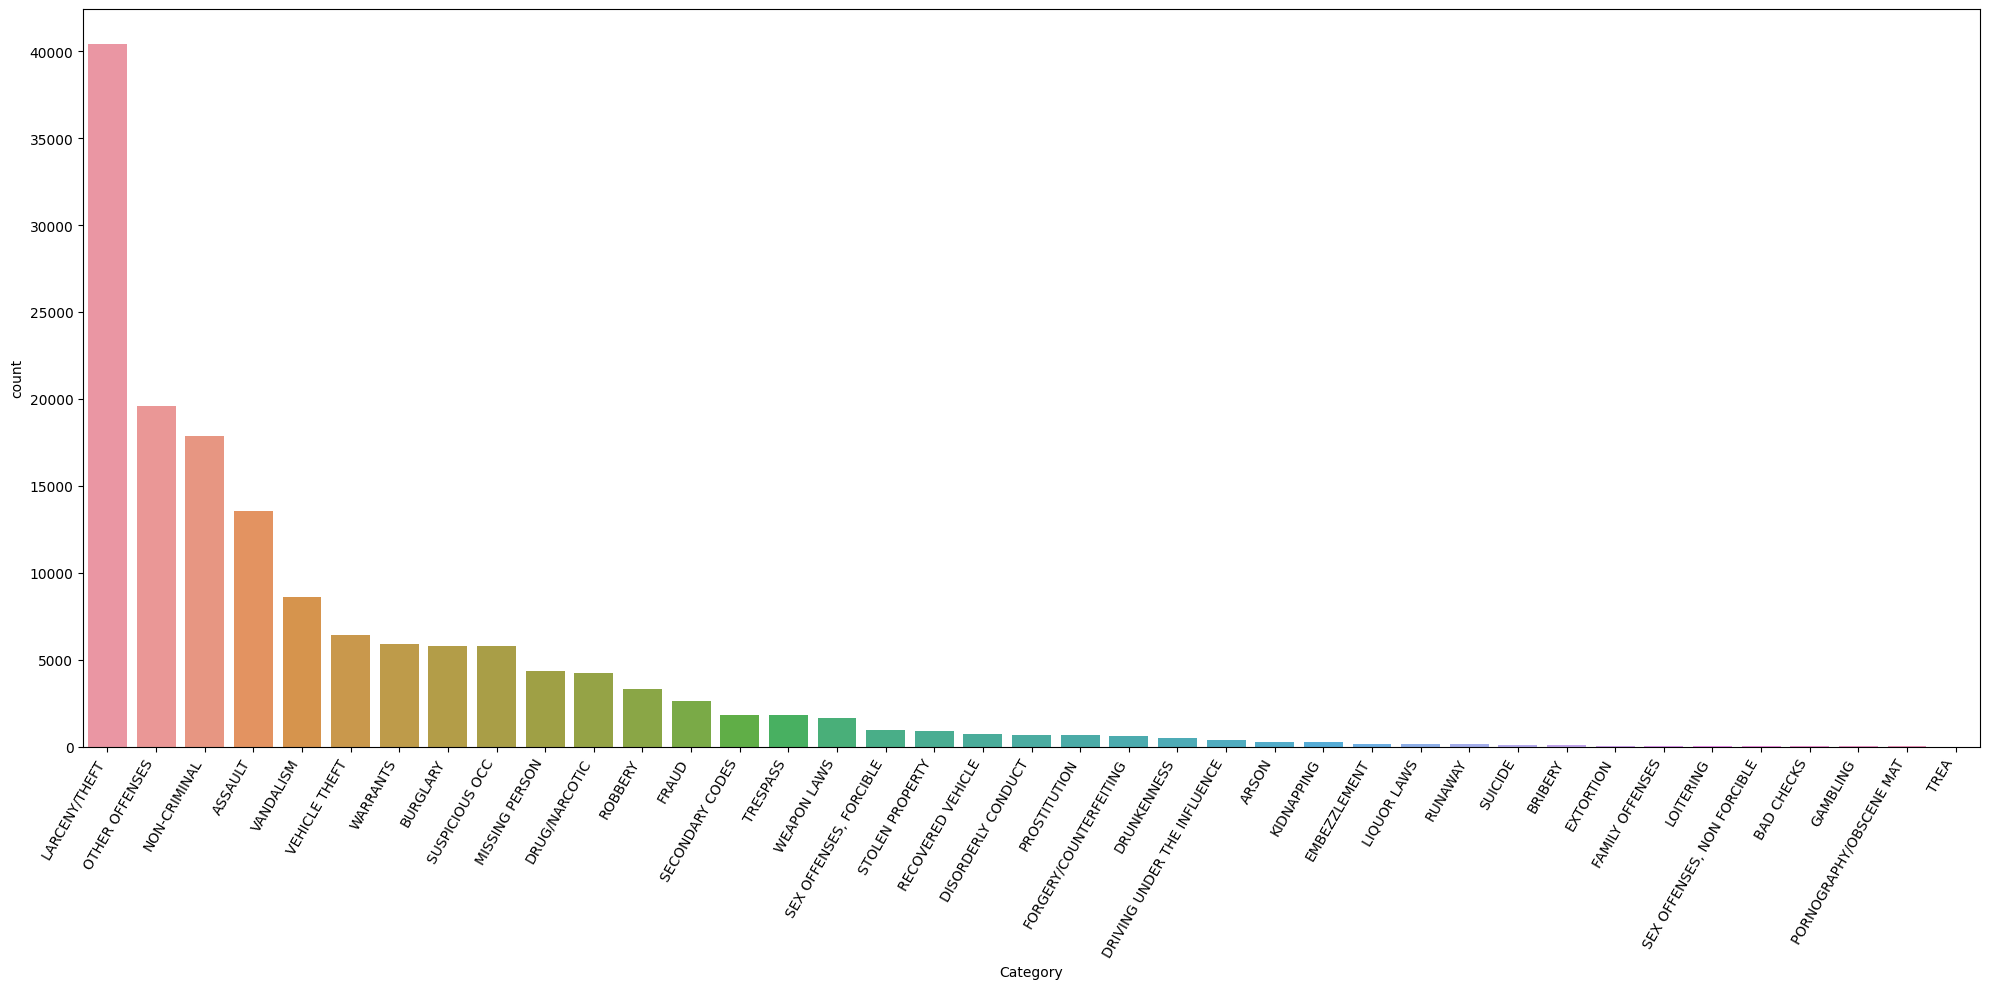

In [11]:
# Distribuzione categorie di crimini 

plt.figure(figsize=(20,10)) 

ax = sns.countplot(x='Category', data= df, order = df['Category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")

plt.tight_layout()
plt.show()

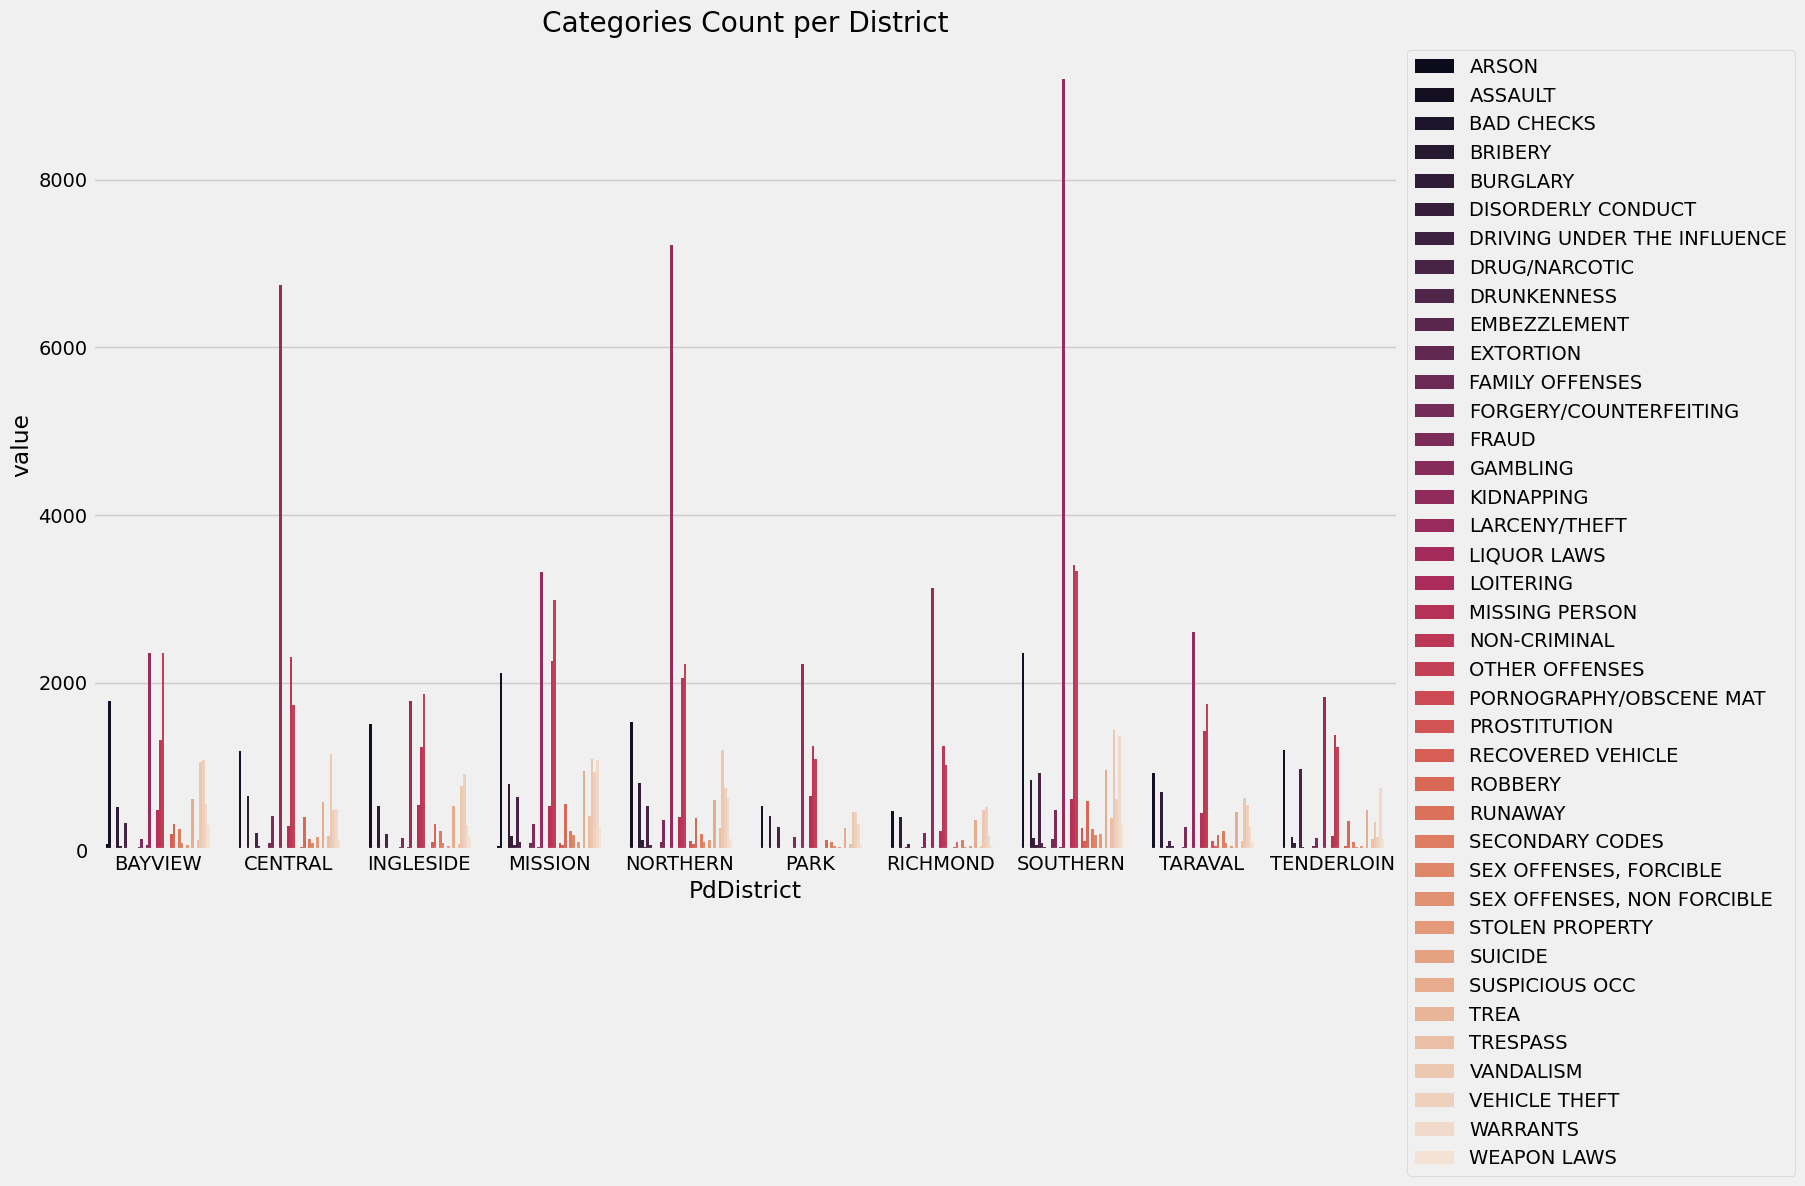

In [12]:
cross_tab_train = pd.crosstab(df['Category'], df['PdDistrict'])
cross_tab_train.style.background_gradient(cmap='mako_r', text_color_threshold=0.02)
stack_sigma_list = cross_tab_train.stack().reset_index().rename(columns= {0:'value'})
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize= (15,10))
    sns.barplot(x=stack_sigma_list['PdDistrict'], y=stack_sigma_list['value'], hue=stack_sigma_list['Category'],  palette='rocket')
    ax.set_title('Categories Count per District')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.show()

In [9]:
# stampo le frequenze assolute per la variabile "Resolution" attraverso la funzione "value_counts()".
df["Resolution"].value_counts()

NONE                                      107779
ARREST, BOOKED                             39416
UNFOUNDED                                   1608
JUVENILE BOOKED                             1056
EXCEPTIONAL CLEARANCE                        371
ARREST, CITED                                144
CLEARED-CONTACT JUVENILE FOR MORE INFO        58
NOT PROSECUTED                                22
LOCATED                                       20
PSYCHOPATHIC CASE                             17
JUVENILE CITED                                 3
JUVENILE DIVERTED                              2
COMPLAINANT REFUSES TO PROSECUTE               2
PROSECUTED BY OUTSIDE AGENCY                   1
Name: Resolution, dtype: int64

In [10]:
# stampo le frequenze assolute per la variabile "Category" attraverso la funzione "value_counts()".
df["Category"].value_counts()

LARCENY/THEFT                  40408
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
L

In [11]:
# Filtro alcune classi di Category perchè: 
# NON-CRIMINAL: Include casi di morte, proprietà ritrovate ecc.. 
# OTHER OFFENSES: Crimini di difficili classificazione  

df = df[~df['Category'].isin(['OTHER OFFENSES', 'NON-CRIMINAL'])]


In [12]:
df['Category'].value_counts()

LARCENY/THEFT                  40408
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
LIQUOR LAWS                      156
RUNAWAY                          140
S

In [13]:
# stampo le frequenze assolute per la variabile "PdDistrict" attraverso la funzione "value_counts()".
df['PdDistrict'].value_counts()

SOUTHERN      21707
NORTHERN      15828
MISSION       14252
CENTRAL       13619
BAYVIEW       10638
INGLESIDE      8491
TARAVAL        8150
TENDERLOIN     7326
RICHMOND       6654
PARK           6369
Name: PdDistrict, dtype: int64

In [14]:
# stampo le frequenze assolute per la variabile "DayOfWeek" attraverso la funzione "value_counts()".
df['DayOfWeek'].value_counts()

Friday       17515
Saturday     16867
Thursday     16122
Tuesday      15826
Wednesday    15821
Monday       15573
Sunday       15310
Name: DayOfWeek, dtype: int64

In [11]:
# la funzione "pd.to_datetime" prende come input la colonna "Date" del dataframe "df" e la converte in un formato di data e ora.
# Il risultato viene assegnato alla stessa colonna del dataframe df, sostituendo il valore originale.
# L'ora è sempre la stessa (12:00:00) in 'Date' , quindi non viene estratta.
#df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d %H:%M:%S")
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y %H:%M:%S %p")
df["Day"] = df["Date"].map(lambda x: x.day)
df["Month"] = df["Date"].map(lambda x: x.month)

#df


C:\Users\nicol\AppData\Local\Temp\ipykernel_10276\895183248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y %H:%M:%S %p")
C:\Users\nicol\AppData\Local\Temp\ipykernel_10276\895183248.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Day"] = df["Date"].map(lambda x: x.day)
C:\Users\nicol\AppData\Local\Temp\ipykernel_10276\895183248.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

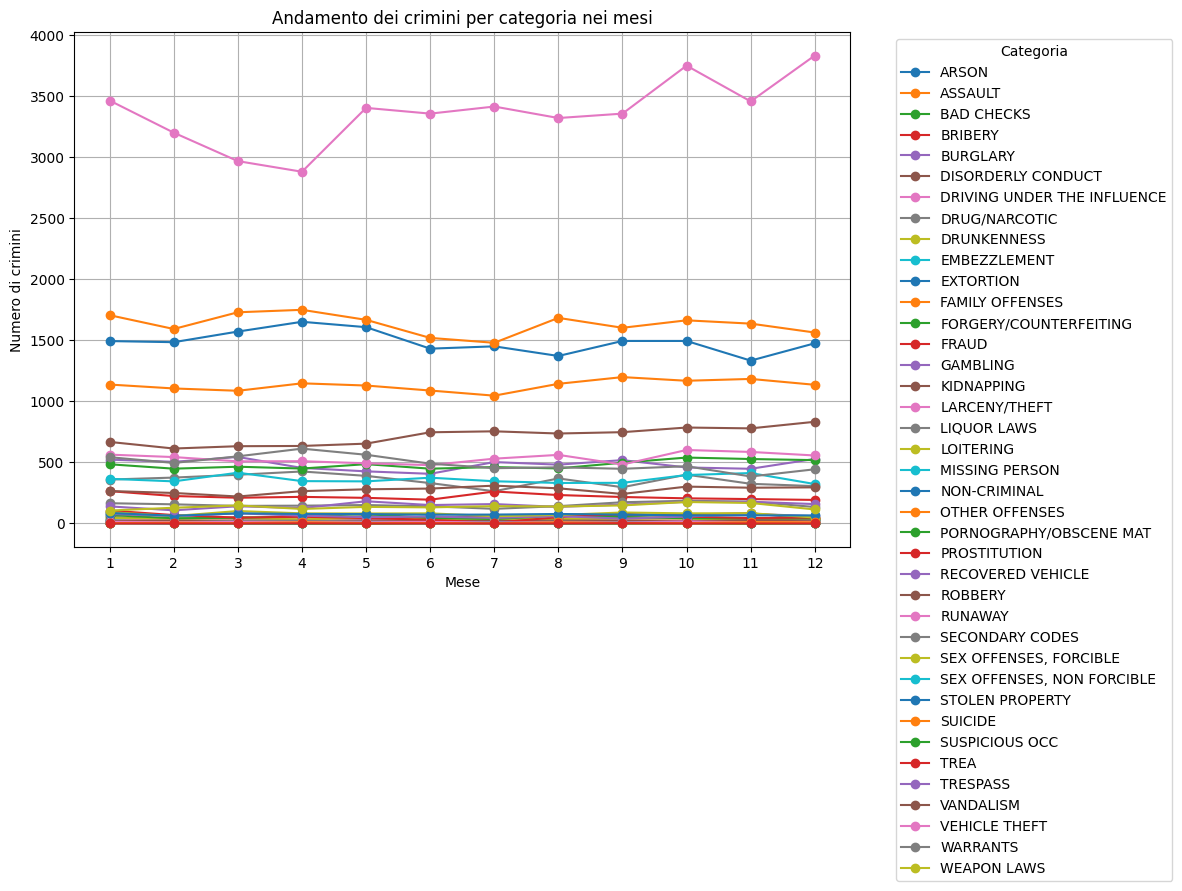

In [23]:
plt.figure(figsize=(12, 8))
for category in crime_counts.columns:
    plt.plot(crime_counts.index, crime_counts[category], label=category, marker='o', linestyle='-')
plt.title('Andamento dei crimini per categoria nei mesi')
plt.xlabel('Mese')
plt.ylabel('Numero di crimini')
plt.xticks(range(1, 13))
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Ricavo l'ora e i minuti  
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M")
df["Hour"] = df["Time"].map(lambda x: x.hour)
#df["Minute"] = df["Time"].map(lambda x: x.minute)


In [17]:
# stampo le frequenze assolute per la variabile "Hour" attraverso la funzione "value_counts()".
df['Hour'].value_counts()

18    7668
19    7198
17    7193
20    6542
16    6388
12    6238
15    6077
21    5968
14    5647
22    5460
13    5288
23    5038
11    4974
0     4896
10    4655
9     4189
8     3959
1     3360
7     2886
2     2726
3     1957
6     1894
4     1467
5     1366
Name: Hour, dtype: int64

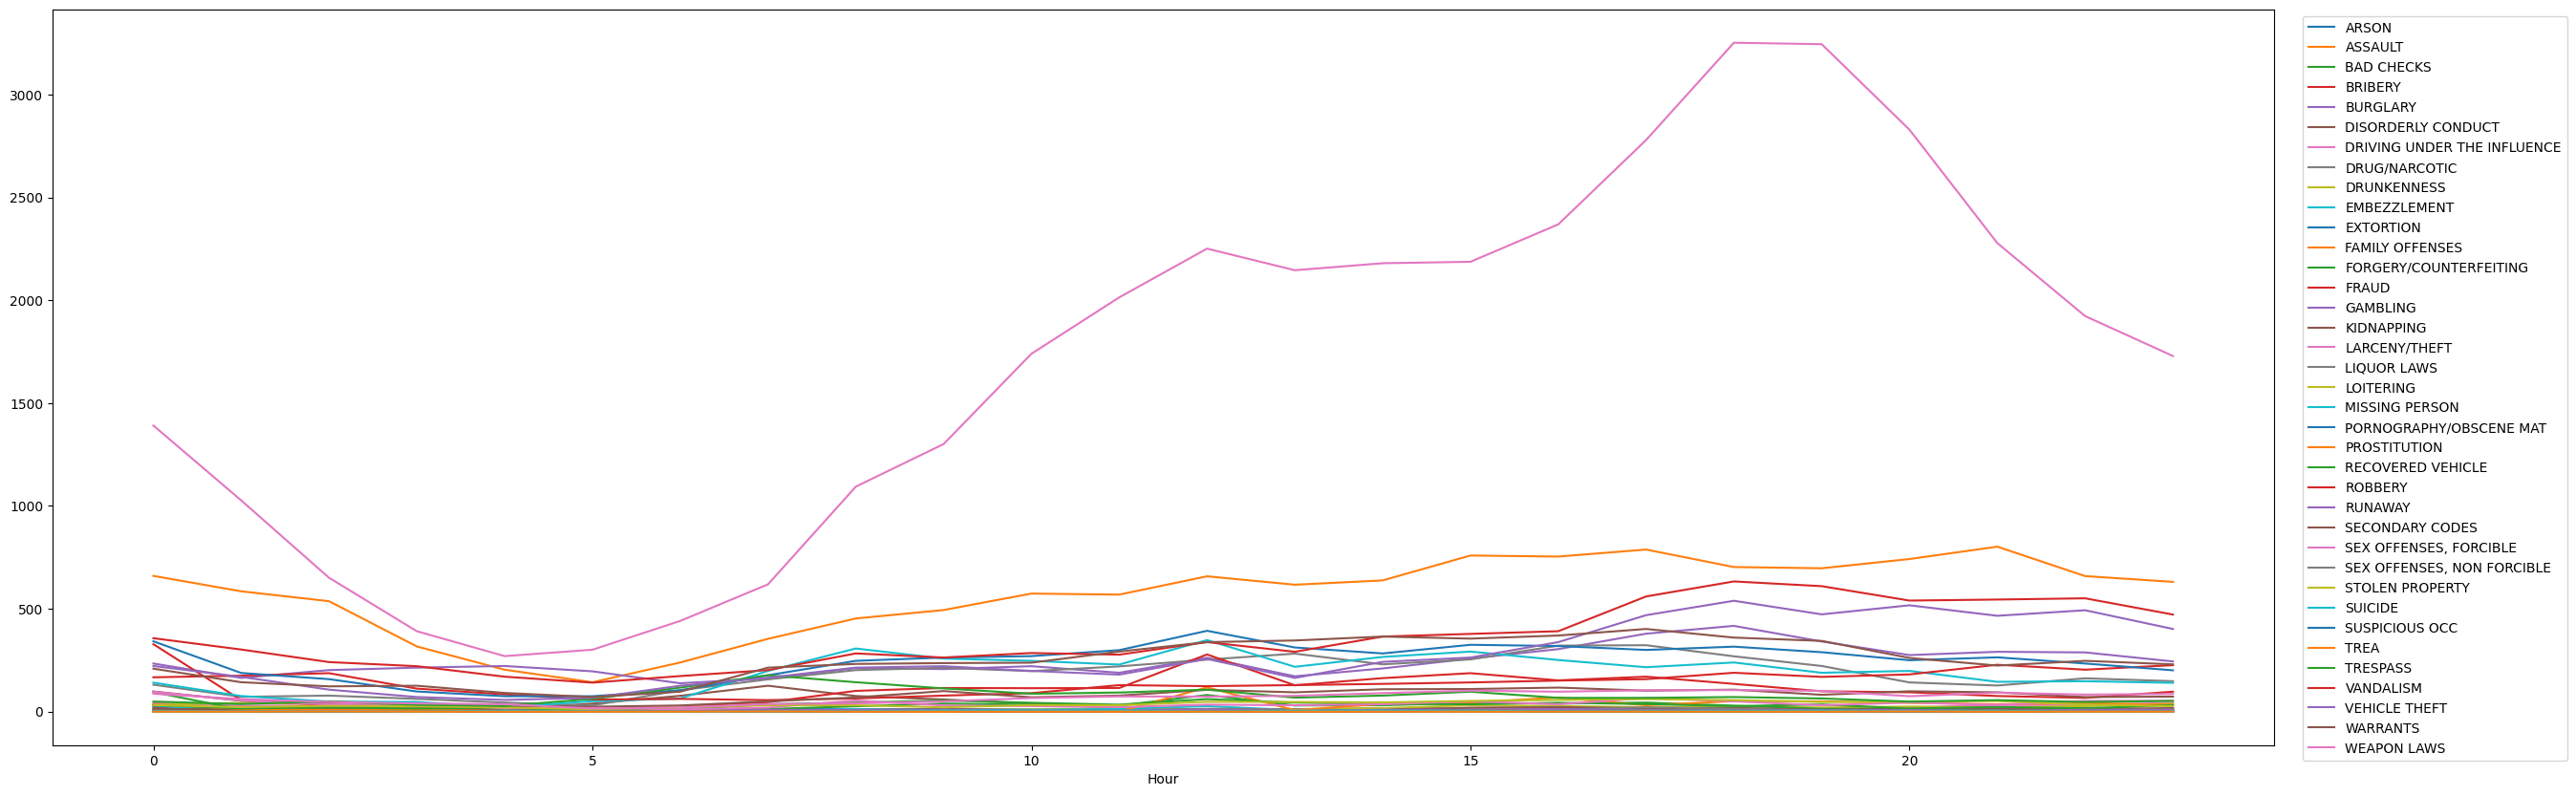

In [18]:
pt = pd.pivot_table(df.loc[:, ['Hour', 'Category']],index="Hour",columns="Category",aggfunc=len,fill_value=0)
pt.plot(figsize=(30,10))
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()

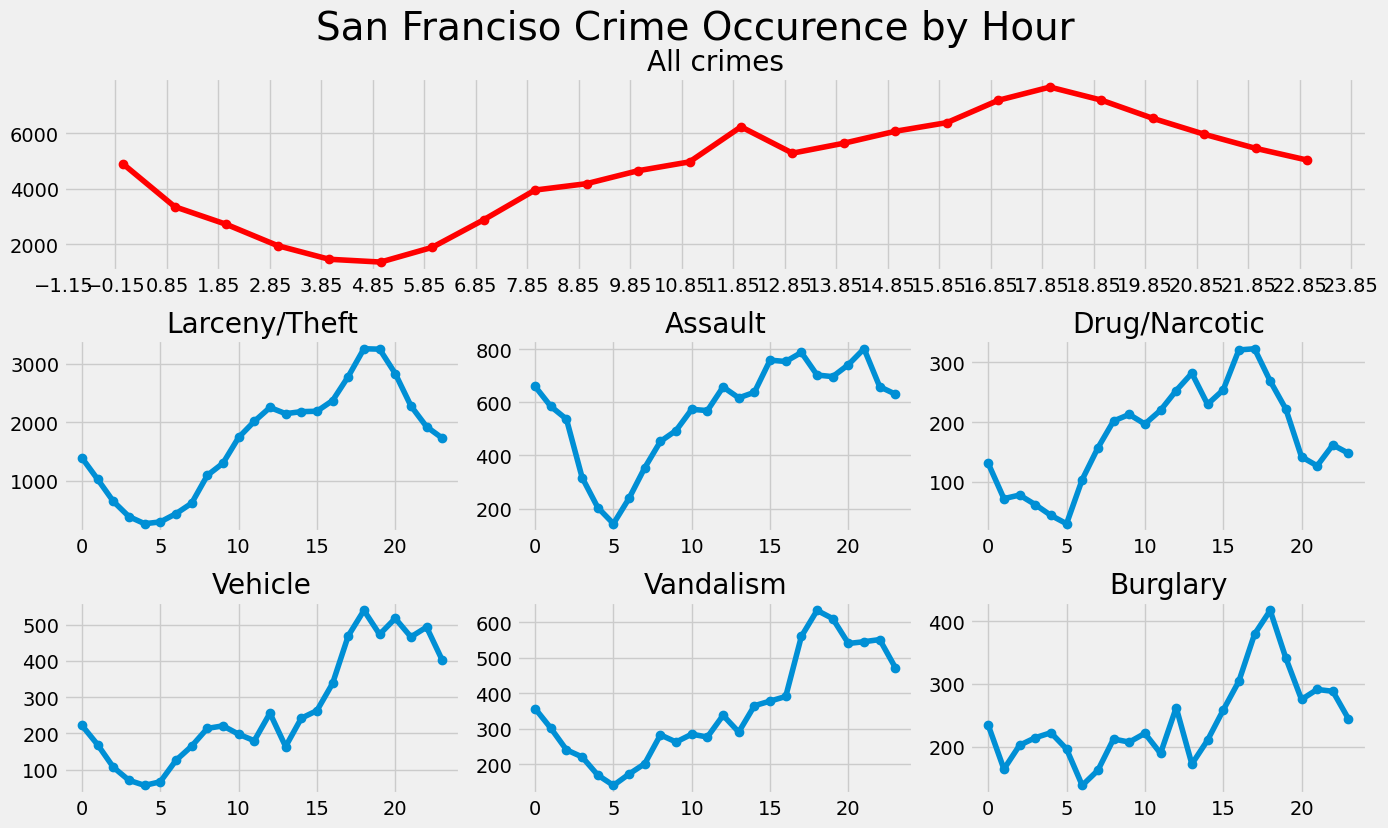

In [19]:
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

larceny = df[df['Category'] == "LARCENY/THEFT"]
assault = df[df['Category'] == "ASSAULT"]
drug = df[df['Category'] == "DRUG/NARCOTIC"]
vehicle = df[df['Category'] == "VEHICLE THEFT"]
vandalism = df[df['Category'] == "VANDALISM"]
burglary = df[df['Category'] == "BURGLARY"]

with plt.style.context('fivethirtyeight'):
    ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
    ax1.plot(df.groupby('Hour').size(), 'ro-')
    ax1.set_title ('All crimes')
    start, end = ax1.get_xlim()
    ax1.xaxis.set_ticks(np.arange(start, end, 1))
    
    ax2 = plt.subplot2grid((3,3), (1, 0))
    ax2.plot(larceny.groupby('Hour').size(), 'o-')
    ax2.set_title ('Larceny/Theft')
    
    ax3 = plt.subplot2grid((3,3), (1, 1))
    ax3.plot(assault.groupby('Hour').size(), 'o-')
    ax3.set_title ('Assault')
    
    ax4 = plt.subplot2grid((3,3), (1, 2))
    ax4.plot(drug.groupby('Hour').size(), 'o-')
    ax4.set_title ('Drug/Narcotic')
    
    ax5 = plt.subplot2grid((3,3), (2, 0))
    ax5.plot(vehicle.groupby('Hour').size(), 'o-')
    ax5.set_title ('Vehicle')
    
    ax6 = plt.subplot2grid((3,3), (2, 1))
    ax6.plot(vandalism.groupby('Hour').size(), 'o-')
    ax6.set_title ('Vandalism')
    
    ax7 = plt.subplot2grid((3,3), (2, 2))
    ax7.plot(burglary.groupby('Hour').size(), 'o-')
    ax7.set_title ('Burglary')
  
    pylab.gcf().text(0.5, 1.03, 
                     'San Franciso Crime Occurence by Hour',
                     horizontalalignment='center',
                     verticalalignment='top', 
                     fontsize = 28)
    
plt.tight_layout()
plt.show()

In [20]:
df['Day'].value_counts()

1     4237
15    3849
16    3848
22    3832
23    3827
27    3808
26    3777
29    3771
21    3727
18    3709
28    3703
12    3695
20    3680
2     3672
17    3664
14    3661
6     3656
4     3651
10    3647
13    3639
19    3637
25    3632
7     3623
24    3622
11    3587
8     3587
9     3574
5     3545
3     3487
30    3421
31    2266
Name: Day, dtype: int64

In [21]:
df['Month'].value_counts()

10    10172
12     9886
1      9745
11     9699
5      9437
9      9375
8      9372
7      9235
6      9124
3      9060
2      9014
4      8915
Name: Month, dtype: int64

In [22]:
# Verifico qual'è il range di coordinate per verificare l'esistenza di eventuali errori
df[['X','Y']].describe()

X              Y
count  113034.000000  113034.000000
mean     -122.423338      37.769432
std         0.026074       0.023549
min      -122.513642      37.707968
25%      -122.433436      37.757173
50%      -122.416734      37.775565
75%      -122.406539      37.785207
max      -122.365565      37.819975

In [23]:
# Periodo del giorno 1 - Dopo mezzanotte, 2 - Mattina, 3 - Pomeriggio, 4 - Sera, 5 - Notte

def get_day_period(hour):
    if hour >= 2 and hour < 8: 
        return 1
    elif hour >= 8 and hour < 12: 
        return 2
    elif hour >= 12 and hour < 18: 
        return 3
    elif hour >= 18 and hour < 22: 
        return 4
    elif hour < 2 or hour >= 22: 
        return 5
    
df["Day_Period"] = df["Hour"].map(get_day_period)
#df

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113034 entries, 0 to 150498
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   IncidntNum  113034 non-null  int64         
 1   Category    113034 non-null  object        
 2   Descript    113034 non-null  object        
 3   DayOfWeek   113034 non-null  object        
 4   Date        113034 non-null  datetime64[ns]
 5   Time        113034 non-null  datetime64[ns]
 6   PdDistrict  113034 non-null  object        
 7   Resolution  113034 non-null  object        
 8   Address     113034 non-null  object        
 9   X           113034 non-null  float64       
 10  Y           113034 non-null  float64       
 11  Location    113034 non-null  object        
 12  PdId        113034 non-null  int64         
 13  Day         113034 non-null  int64         
 14  Month       113034 non-null  int64         
 15  Hour        113034 non-null  int64         
 16  Da

In [25]:
df['Address'].value_counts().index

Index(['800 Block of BRYANT ST', '800 Block of MARKET ST',
       '1000 Block of POTRERO AV', '900 Block of MARKET ST',
       '500 Block of JOHNFKENNEDY DR', '3200 Block of 20TH AV',
       '800 Block of MISSION ST', '100 Block of OFARRELL ST',
       '0 Block of UNITEDNATIONS PZ', '1000 Block of POINTLOBOS AV',
       ...
       '12TH AV / BALBOA ST', '37TH AV / PACHECO ST', 'PRAGUE ST / BRAZIL AV',
       'MISSION ST / FARRAGUT AV', 'MARVIEW WY / PALOALTO AV',
       '200 Block of RIVERA ST', '800 Block of DELANO AV',
       'OCTAVIA ST / VALLEJO ST', 'DIAMOND ST / 24TH ST',
       '100 Block of EDNA ST'],
      dtype='object', length=14759)

In [26]:
#Ricavo la tipologia di strada dove è avvenuto il crimine:  avenues, streets, ways, boulevards, highways, courts, walks, plazas e diversi tipi di incroci di strade (Indirizzi con /).
   
def find_streets(address):
    street_types = ['AV', 'ST', 'CT', 'PZ', 'LN', 'DR', 'PL', 'HY', 
                    'WY', 'TR', 'RD', 'BL', 'WAY', 'CR', 'AL']
    street_pattern = '|'.join(street_types)
    streets = re.findall(street_pattern, address)
    if len(streets) == 0:
        # Debug
#         print(address)
        return 'OTHER'
    elif len(streets) == 1:
        return streets[0]
    else:
#         print(address)
        return 'INT'

df['StreetType'] = df['Address'].map(find_streets)

In [27]:
df['StreetType'].value_counts()

INT    49180
ST     46660
AV     12025
BL      1923
DR      1240
WY       482
PZ       328
CT       294
RD       251
LN       192
HY       169
PL       132
TR       111
CR        26
AL        14
WAY        7
Name: StreetType, dtype: int64

In [28]:
# Verifico presenza di valori nulli 
df['StreetType'].isnull().sum()

0

In [29]:
# Raggruppo alcune categorie per similarità
crime_categories = {
    "PropertyCrimes":  ["LARCENY/THEFT", "VEHICLE THEFT" , "VANDALISM" , "ROBBERY" , "STOLEN PROPERTY", "ARSON" , "RECOVERED VEHICLE", "EMBEZZLEMENT", "FRAUD", "BURGLARY", "EXTORTION"],
     "ViolentCrimes": ["ASSAULT","KIDNAPPING", "SEX OFFENSES, FORCIBLE", "SECONDARY CODES", "SUICIDE"],
     "QoLCrimes": ["LOITERING","PROSTITUTION" ,"LIQUOR LAWS","TRESPASS","TREA", "DRUG/NARCOTIC","DRIVING UNDER THE INFLUENCE", "DRUNKENNESS", "FAMILY OFFENSES", "SEX OFFENSES, NON FORCIBLE", "GAMBLING", "DISORDERLY CONDUCT"],
     "OtherCrimes": ["SUSPICIOUS OCC","MISSING PERSON","FORGERY/COUNTERFEITING","RUNAWAY","BRIBERY","BAD CHECKS","PORNOGRAPHY/OBSCENE MAT", "WARRANTS", "WEAPON LAWS"]
    
}

df["Category"]= df["Category"].apply(lambda x: next((k for k, v in crime_categories.items() if x in v), x))

In [30]:
df["Category"].value_counts()

PropertyCrimes    69284
OtherCrimes       18555
ViolentCrimes     16684
QoLCrimes          8511
Name: Category, dtype: int64

In [31]:
# Elimino occorrenze di OtherCrimes perchè non ci sono similarità tra loro per poterle raggruppare tutte in un'unica categoria 
df = df[~df['Category'].isin(['OtherCrimes'])]

In [32]:

df["Category"].value_counts()

PropertyCrimes    69284
ViolentCrimes     16684
QoLCrimes          8511
Name: Category, dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94479 entries, 5 to 150498
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   IncidntNum  94479 non-null  int64         
 1   Category    94479 non-null  object        
 2   Descript    94479 non-null  object        
 3   DayOfWeek   94479 non-null  object        
 4   Date        94479 non-null  datetime64[ns]
 5   Time        94479 non-null  datetime64[ns]
 6   PdDistrict  94479 non-null  object        
 7   Resolution  94479 non-null  object        
 8   Address     94479 non-null  object        
 9   X           94479 non-null  float64       
 10  Y           94479 non-null  float64       
 11  Location    94479 non-null  object        
 12  PdId        94479 non-null  int64         
 13  Day         94479 non-null  int64         
 14  Month       94479 non-null  int64         
 15  Hour        94479 non-null  int64         
 16  Day_Period  94479 non

## Eliminazione features ridondanti

#### Elimino 'Date' , 'Time' e 'Location' perchè le rispettive informazioni sono già incluse in altre colonne. 
#### Elimino 'Descript' perchè non considero i dettagli ulteriori rispetto alla feature 'Category'. 
#### Elimino 'Address' perchè mi basta la tipologia di indirizzo e il distretto. 
#### Elimino 'IncidntNum' e 'PdId' perchè sono rispettivamente identificativi degli incidenti e del poliziotto. 
#### Elimino 'Hour' perchè mi basta sapere il periodo del giorno (tramite la feature 'Day_Period')


In [34]:
# Uso la funzione drop per eliminare le colonne descritte sopra
df = df.drop(['Date','Time','Location', 'Descript', 'Address', 'X', 'Y','PdId', 'IncidntNum', 'Hour', 'Resolution'], axis=1)


In [35]:
df

Category DayOfWeek PdDistrict  Day  Month  Day_Period StreetType
5        ViolentCrimes    Friday   NORTHERN    1      1           4         ST
10      PropertyCrimes    Friday    TARAVAL   29      1           5         AV
13       ViolentCrimes  Thursday  INGLESIDE   15      9           1        INT
14      PropertyCrimes  Saturday    CENTRAL    2      1           5         ST
15      PropertyCrimes  Saturday   SOUTHERN    2      1           2         ST
...                ...       ...        ...  ...    ...         ...        ...
150493   ViolentCrimes    Friday    MISSION   21     10           3         ST
150494   ViolentCrimes  Thursday    BAYVIEW    1      9           5         ST
150495   ViolentCrimes    Friday       PARK   30     12           4        INT
150497  PropertyCrimes  Thursday    CENTRAL   29     12           4        INT
150498  PropertyCrimes    Friday    CENTRAL   30     12           2        INT

[94479 rows x 7 columns]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94479 entries, 5 to 150498
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Category    94479 non-null  object
 1   DayOfWeek   94479 non-null  object
 2   PdDistrict  94479 non-null  object
 3   Day         94479 non-null  int64 
 4   Month       94479 non-null  int64 
 5   Day_Period  94479 non-null  int64 
 6   StreetType  94479 non-null  object
dtypes: int64(3), object(4)
memory usage: 5.8+ MB


In [37]:
# separo le features e la variabile target.
#X = df[['DayOfWeek', 'PdDistrict', 'Resolution','Month', 'Day', 'Day_Period', 'StreetType']]
#X = df['DayOfWeek', 'PdDistrict', 'Day_Period', 'StreetType']
X= df.drop(['Category', 'Day', 'Month'], axis=1)
Y = df["Category"]

In [38]:
Y.info()

<class 'pandas.core.series.Series'>
Int64Index: 94479 entries, 5 to 150498
Series name: Category
Non-Null Count  Dtype 
--------------  ----- 
94479 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


In [39]:

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94479 entries, 5 to 150498
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DayOfWeek   94479 non-null  object
 1   PdDistrict  94479 non-null  object
 2   Day_Period  94479 non-null  int64 
 3   StreetType  94479 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.6+ MB


In [40]:
# Divido le features in categoriche e numeriche 

#features_num = []

features_cat = [
    'Day_Period',
    'DayOfWeek',
    'PdDistrict',
    'StreetType',
]

In [41]:
# Codifico tutte le features categoriche in numeriche
X_cat = X[features_cat]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X_cat), columns=encoder.get_feature_names_out(features_cat))
X= X_encoded
#X = pd.concat([X.drop(features_cat, axis=1), X_encoded], axis=1)

In [42]:
X

Day_Period_1  Day_Period_2  Day_Period_3  Day_Period_4  Day_Period_5  \
0               0.0           0.0           0.0           1.0           0.0   
1               0.0           0.0           0.0           0.0           1.0   
2               1.0           0.0           0.0           0.0           0.0   
3               0.0           0.0           0.0           0.0           1.0   
4               0.0           1.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
94474           0.0           0.0           1.0           0.0           0.0   
94475           0.0           0.0           0.0           0.0           1.0   
94476           0.0           0.0           0.0           1.0           0.0   
94477           0.0           0.0           0.0           1.0           0.0   
94478           0.0           1.0           0.0           0.0           0.0   

       DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  \
0                   1.0               0.0                 0.0   
1                   1.0               0.0                 0.0   
2                   0.0               0.0                 0.0   
3                   0.0               0.0                 1.0   
4                   0.0               0.0                 1.0   
...                 ...               ...                 ...   
94474               1.0               0.0                 0.0   
94475               0.0               0.0                 0.0   
94476               1.0               0.0                 0.0   
94477               0.0               0.0                 0.0   
94478               1.0               0.0                 0.0   

       DayOfWeek_Sunday  DayOfWeek_Thursday  ...  StreetType_HY  \
0                   0.0                 0.0  ...            0.0   
1                   0.0                 0.0  ...            0.0   
2                   0.0                 1.0  ...            0.0   
3                   0.0                 0.0  ...            0.0   
4                   0.0                 0.0  ...            0.0   
...                 ...                 ...  ...            ...   
94474               0.0                 0.0  ...            0.0   
94475               0.0                 1.0  ...            0.0   
94476               0.0                 0.0  ...            0.0   
94477               0.0                 1.0  ...            0.0   
94478               0.0                 0.0  ...            0.0   

       StreetType_INT  StreetType_LN  StreetType_PL  StreetType_PZ  \
0                 0.0            0.0            0.0            0.0   
1                 0.0            0.0            0.0            0.0   
2                 1.0            0.0            0.0            0.0   
3                 0.0            0.0            0.0            0.0   
4                 0.0            0.0            0.0            0.0   
...               ...            ...            ...            ...   
94474             0.0            0.0            0.0            0.0   
94475             0.0            0.0            0.0            0.0   
94476             1.0            0.0            0.0            0.0   
94477             1.0            0.0            0.0            0.0   
94478             1.0            0.0            0.0            0.0   

       StreetType_RD  StreetType_ST  StreetType_TR  StreetType_WAY  \
0                0.0            1.0            0.0             0.0   
1                0.0            0.0            0.0             0.0   
2                0.0            0.0            0.0             0.0   
3                0.0            1.0            0.0             0.0   
4                0.0            1.0            0.0             0.0   
...              ...            ...            ...             ...   
94474            0.0            1.0            0.0             0.0   
94475            0.0            1.0            0.0             0.0   
9

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94479 entries, 0 to 94478
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Day_Period_1           94479 non-null  float64
 1   Day_Period_2           94479 non-null  float64
 2   Day_Period_3           94479 non-null  float64
 3   Day_Period_4           94479 non-null  float64
 4   Day_Period_5           94479 non-null  float64
 5   DayOfWeek_Friday       94479 non-null  float64
 6   DayOfWeek_Monday       94479 non-null  float64
 7   DayOfWeek_Saturday     94479 non-null  float64
 8   DayOfWeek_Sunday       94479 non-null  float64
 9   DayOfWeek_Thursday     94479 non-null  float64
 10  DayOfWeek_Tuesday      94479 non-null  float64
 11  DayOfWeek_Wednesday    94479 non-null  float64
 12  PdDistrict_BAYVIEW     94479 non-null  float64
 13  PdDistrict_CENTRAL     94479 non-null  float64
 14  PdDistrict_INGLESIDE   94479 non-null  float64
 15  Pd

In [44]:
X.describe()

Day_Period_1  Day_Period_2  Day_Period_3  Day_Period_4  Day_Period_5  \
count  94479.000000  94479.000000  94479.000000  94479.000000  94479.000000   
mean       0.108035      0.150912      0.319934      0.252077      0.169043   
std        0.310426      0.357965      0.466453      0.434208      0.374792   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  \
count      94479.000000      94479.000000        94479.000000   
mean           0.155707          0.137893            0.151399   
std            0.362579          0.344790            0.358439   
min            0.000000          0.000000            0.000000   
25%            0.000000          0.000000            0.000000   
50%            0.000000          0.000000            0.000000   
75%            0.000000          0.000000            0.000000   
max            1.000000          1.000000            1.000000   

       DayOfWeek_Sunday  DayOfWeek_Thursday  ...  StreetType_HY  \
count      94479.000000        94479.000000  ...   94479.000000   
mean           0.137470            0.141428  ...       0.001577   
std            0.344344            0.348465  ...       0.039681   
min            0.000000            0.000000  ...       0.000000   
25%            0.000000            0.000000  ...       0.000000   
50%            0.000000            0.000000  ...       0.000000   
75%            0.000000            0.000000  ...       0.000000   
max            1.000000            1.000000  ...       1.000000   

       StreetType_INT  StreetType_LN  StreetType_PL  StreetType_PZ  \
count    94479.000000   94479.000000   94479.000000   94479.000000   
mean         0.440278       0.001418       0.001270       0.002011   
std          0.496423       0.037634       0.035616       0.044800   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          1.000000       0.000000       0.000000       0.000000   
max          1.000000       1.000000       1.000000       1.000000   

       StreetType_RD  StreetType_ST  StreetType_TR  StreetType_WAY  \
count   94479.000000   94479.000000   94479.000000    94479.000000   
mean        0.001958       0.410049       0.000889        0.000064   
std         0.044207       0.491845       0.029804        0.007969   
min         0.000000       0.000000       0.000000        0.000000   
25%         0.000000       0.000000       0.000000        0.000000   
50%         0.000000       0.000000       0.000000        0.000000   
75%         0.000000       1.000000       0.000000        0.000000   
max         1.000000       1.000000       1.000000        1.000000   

       StreetType_WY  
count   94479.000000  
mean        0.004022  
std         0.063292  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 38 columns]

In [45]:
le = LabelEncoder()
Y = le.fit_transform(Y)
dict(zip(le.classes_, le.transform(le.classes_)))



{'PropertyCrimes': 0, 'QoLCrimes': 1, 'ViolentCrimes': 2}

In [46]:
Y

array([2, 0, 2, ..., 2, 0, 0])

## Building Machine Learning Models 

In [47]:
# creo un'istanza della classe StandardScaler() e la assegno alla variabile "scaler". 
scaler = StandardScaler()
# utilizzo il metodo fit_transform() sull'oggetto scaler e passo la matrice di dati "X" come input.
# Il metodo fit_transform() esegue la trasformazione di scaling sui dati, ovvero li standardizza,
# e restituisce la matrice di dati standadizzata come output, che viene assegnata alla variabile X_scaled.
X_scaled = scaler.fit_transform(X)


In [48]:
# utilizzo la funzione "train_test_split" per dividere i dati in due gruppi:
# uno per l'allenamento (X_train e Y_train) e uno per il test (X_test e Y_test).
# La "random_state" garantisce che i dati vengano sempre divisi nello stesso modo.

X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=.25, random_state = 0)

## Cross-Validation

In [49]:
# creo diverse istanze di classificatori di modelli di apprendimento automatico
dt = DecisionTreeClassifier()
gnb = GaussianNB()
rf = RandomForestClassifier()
lr = LogisticRegression()
xgb= XGBClassifier()
# inserisco questi modelli in una lista chiamata "models"...
models = [dt, gnb, rf, lr, xgb]

# ... e li utilizzo in un ciclo "for" per eseguire la validazione incrociata a 5 riprese sui dati "X_train_nm1" e "Y_train_nm1".
for model in models:
    # La funzione cross_val_score() viene utilizzata per calcolare le prestazioni del modello sui dati di input
    # utilizzando la validazione incrociata a 5 riprese, cioè il modello viene addestrato su 4/5 dei dati e testato su 1/5 dei dati,
    # questo processo viene ripetuto 5 volte utilizzando un diverso insieme di dati per il test ogni volta.
    scores = cross_val_score(model, X_train, Y_train, cv=5)
    # Stampo i risultati delle valutazioni per ogni modello, mostrando i punteggi di validazione incrociata...
    print("Cross-validation scores for {}: {}".format(model.__class__.__name__,scores))
    # ...e la media dei punteggi per ogni modello.
    print("Mean cross-validation score for {}: {:.2f}\n".format(model.__class__.__name__,scores.mean()))

Cross-validation scores for DecisionTreeClassifier: [0.73525261 0.73087779 0.73186565 0.73362969 0.73248183]
Mean cross-validation score for DecisionTreeClassifier: 0.73

Cross-validation scores for GaussianNB: [0.17710979 0.15177815 0.11057014 0.10852385 0.11163644]
Mean cross-validation score for GaussianNB: 0.13

Cross-validation scores for RandomForestClassifier: [0.73426475 0.73108947 0.73108947 0.73419419 0.73262296]
Mean cross-validation score for RandomForestClassifier: 0.73

Cross-validation scores for LogisticRegression: [0.73461756 0.73419419 0.73341801 0.73504093 0.73396373]
Mean cross-validation score for LogisticRegression: 0.73

Cross-validation scores for XGBClassifier: [0.73588767 0.73264183 0.73497036 0.73631104 0.73375203]
Mean cross-validation score for XGBClassifier: 0.73



## Modelli

In [50]:
# definisco una funzione chiamata "model" che prende come input un classificatore "clf"
# (ad esempio, una istanza di una classe RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, GaussianNB o XGBoost). 
def model_fn(clf, X, Y):  
    # imposto un seed in modo da garantire la riproducibilità dei risultati
    np.random.seed(0)
    # Utilizzo il classificatore "clf" per addestrare il modello sull'insieme di dati di formazione "X" e "Y".
    clf.fit(X, Y)
    # Utilizzo il modello addestrato per fare previsioni sull'insieme di dati di test "X_test" e assegno le previsioni alla variabile "Y_pred".
    Y_pred = clf.predict(X_test)
    # Calcolo la matrice di confusione utilizzando le etichette effettive "Y_test" e le previsioni "Y_pred" e
    # assegno il risultato alla variabile "cm". Utilizzo "clf.classes_" come elenco di etichette.
    cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
    # Calcolo la precisione di addestramento utilizzando "clf.score" sui dati di addestramento e assegno il risultato alla variabile "acc_train". 
    acc_train = clf.score(X, Y)
    # Calcolo anche la precisione di test utilizzando "clf.score" sui dati di test e assegno il risultato alla variabile "acc_test".
    acc_test = clf.score(X_test, Y_test)
    # Creo un dizionario chiamato "classifier_names" che associa i nomi dei classificatori ai loro oggetti.
    #classifier_names = {rf: "Random Forest", dt: "Decision Tree", lr: "Logistic Regression", gnb: "Gaussian Naive Bayes", xgb: "XGBoost"}
    # Utilizzo la funzione get() per prendere il nome del classificatore dal dizionario "classifier_names".
    # Stampo il nome del classificatore, la precisione di addestramento e la precisione di test.
    #print(classifier_names.get(clf))
    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))
    # utilizzo tre funzioni di sklearn per calcolare la precisione, la recall e il punteggio F1 
    # dei dati previsti (Y_pred) rispetto ai dati di test effettivi (Y_test).
    # "average = macro" fa in modo che a ciascuna classe venga assegnata la stessa importanza,
    # normalmente quindi non terrebbe conto di un possibile sbilanciamento
    precision = precision_score(Y_test, Y_pred, average='macro')
    recall = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='macro')
    print("Precision:", round(precision, 4))
    print("Recall:", round(recall, 4))
    print("F1 Score:", round(f1, 4),"\n")
    # Stampo un report di classificazione utilizzando la funzione classification_report.
    print(classification_report(Y_test, Y_pred))
    # Utilizzo la funzione 'ConfusionMatrixDisplay' per visualizzare la matrice di confusione.
    disp = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, labels=clf.classes_, cmap=plt.cm.Blues) 
    fig = disp.figure_
    fig.set_figwidth(10)
    fig.set_figheight(10) 
    #fig.suptitle('Plot of confusion matrix')

Training Accuracy: 0.7401
Test Accuracy: 0.732
Precision: 0.5486
Recall: 0.3558
F1 Score: 0.3307 

              precision    recall  f1-score   support

           0       0.74      0.99      0.84     17290
           1       0.53      0.05      0.10      2157
           2       0.38      0.03      0.05      4173

    accuracy                           0.73     23620
   macro avg       0.55      0.36      0.33     23620
weighted avg       0.66      0.73      0.64     23620



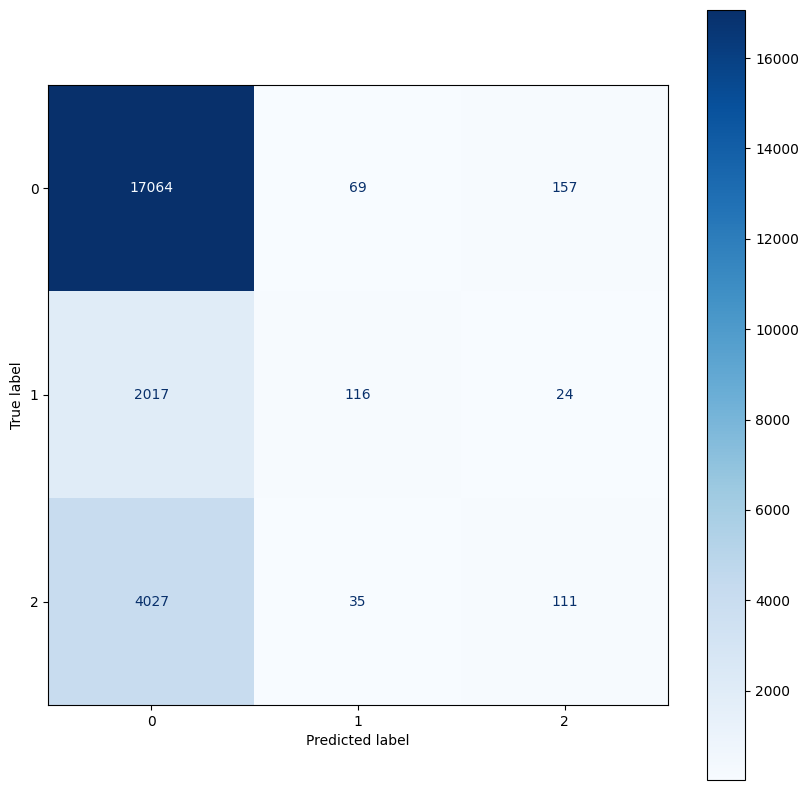

In [51]:
# scelgo come input tra quelli disponibili: 
# rf (Random Forest)
model_fn(rf, X_train, Y_train)

Training Accuracy: 0.7401
Test Accuracy: 0.7328
Precision: 0.5581
Recall: 0.3551
F1 Score: 0.3288 

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     17290
           1       0.54      0.05      0.09      2157
           2       0.40      0.02      0.05      4173

    accuracy                           0.73     23620
   macro avg       0.56      0.36      0.33     23620
weighted avg       0.66      0.73      0.64     23620



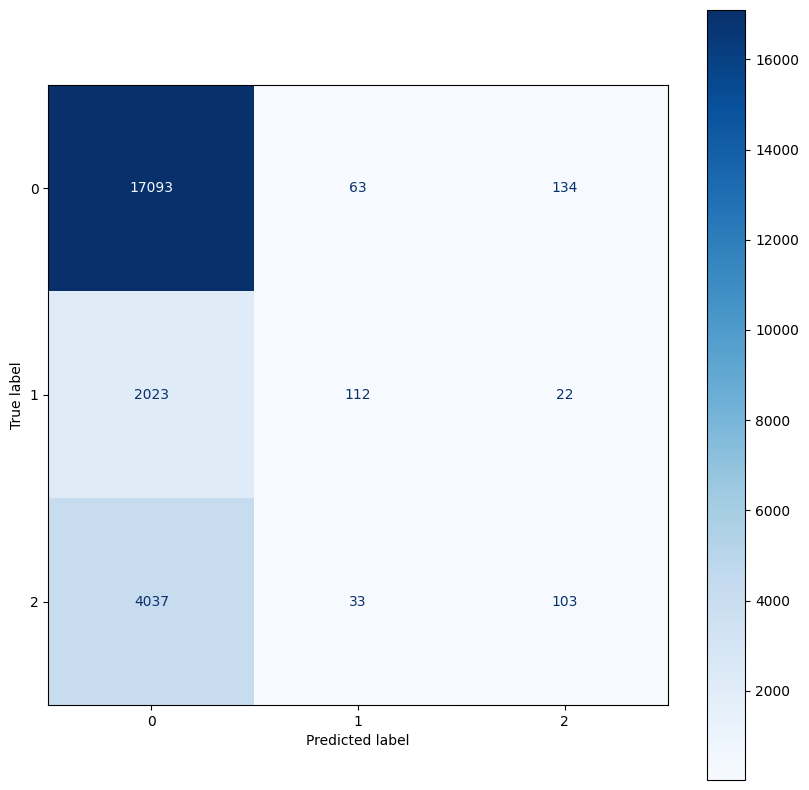

In [52]:
# scelgo come input tra quelli disponibili: 
# dt (Decision Tree)
model_fn(dt, X_train, Y_train)

Training Accuracy: 0.1542
Test Accuracy: 0.1542
Precision: 0.4214
Recall: 0.3543
F1 Score: 0.123 

              precision    recall  f1-score   support

           0       0.84      0.09      0.16     17290
           1       0.10      0.96      0.17      2157
           2       0.33      0.02      0.04      4173

    accuracy                           0.15     23620
   macro avg       0.42      0.35      0.12     23620
weighted avg       0.68      0.15      0.14     23620



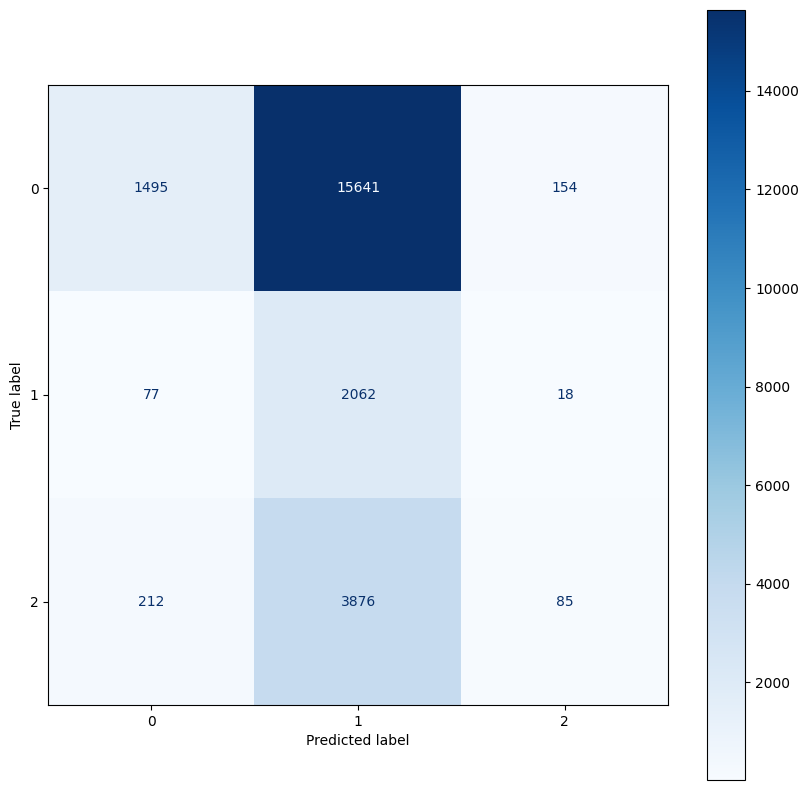

In [53]:
# scelgo come input tra quelli disponibili: 
# gnb (Gaussian Naive Bayes)
model_fn(gnb, X_train, Y_train)

Training Accuracy: 0.7343
Test Accuracy: 0.7326
Precision: 0.6162
Recall: 0.3374
F1 Score: 0.291 

              precision    recall  f1-score   support

           0       0.73      1.00      0.85     17290
           1       0.62      0.01      0.01      2157
           2       0.50      0.01      0.01      4173

    accuracy                           0.73     23620
   macro avg       0.62      0.34      0.29     23620
weighted avg       0.68      0.73      0.62     23620



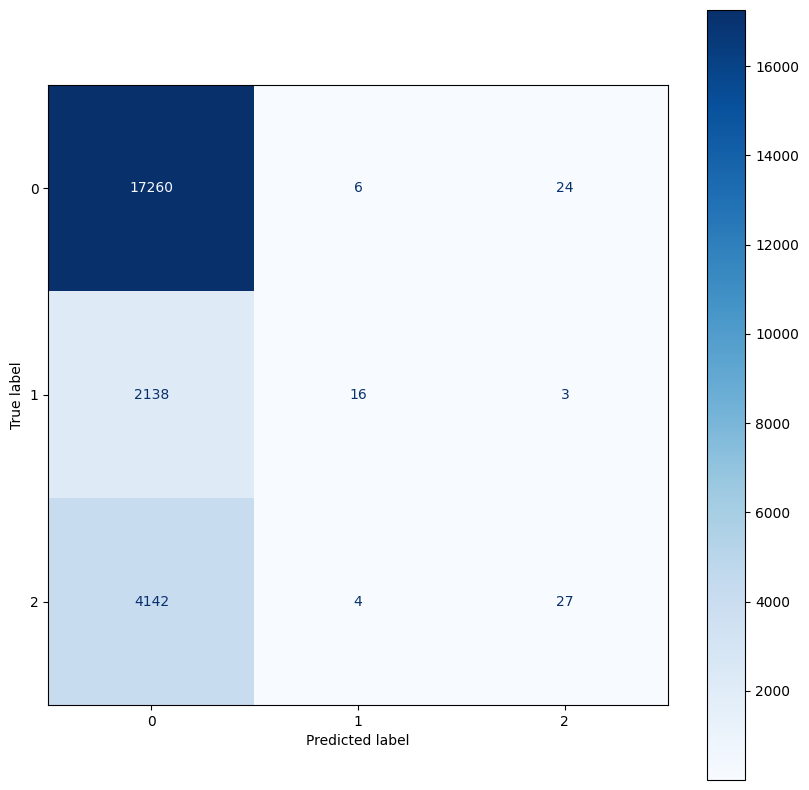

In [54]:
# scelgo come input tra quelli disponibili: 
# lr (Logistic Regression)
model_fn(lr, X_train, Y_train)

Training Accuracy: 0.7382
Test Accuracy: 0.7339
Precision: 0.5942
Recall: 0.3485
F1 Score: 0.3143 

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     17290
           1       0.57      0.04      0.07      2157
           2       0.48      0.01      0.03      4173

    accuracy                           0.73     23620
   macro avg       0.59      0.35      0.31     23620
weighted avg       0.68      0.73      0.63     23620



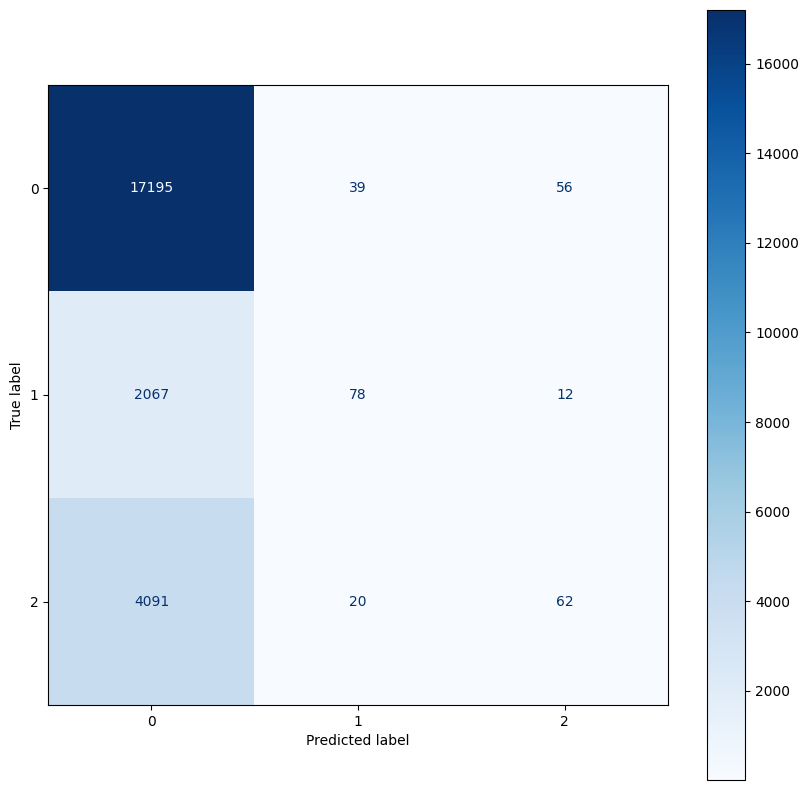

In [55]:
# scelgo come input tra quelli disponibili: 
# XGB (XGradientBoosting)
model_fn(xgb, X_train, Y_train)

## RandomForest e DecisionTree risultano i classificatori con la migliore accuracy del 74%. Quindi proseguo l'analisi più approfondita con questi due 

# HyperParameter tuning per RandomForestClassifier


In [56]:
#funzione che stampa i parametri 

def best_parameter(clf, index_param): 
  # Stampo migliori parametri 
  print('Best parameters found  :\n', clf.best_params_)
  # Accuracy al variare dei parametri
  results = pd.DataFrame(clf.cv_results_)
  res = results.pivot_table(index= index_param, values=["mean_test_score", "std_test_score"])
  res.mean_test_score.plot(yerr=res.std_test_score)
  #res.mean_train_score.plot(yerr=res.std_train_score)
  plt.legend()

In [57]:
# Set di parametri da ottimizzare

parameter_space = {
    'n_estimators': [100,200,300,500], 
    'max_features': ['sqrt', 'log2', None],  
    'min_samples_leaf': [1,10,20]
    #'min_samples_split': [2,10,20], 
    #'criterion' : ['gini' , 'entropy']
}

## GridSearchCV

In [58]:
clf_rf = GridSearchCV(rf, parameter_space, cv=5)

Training Accuracy: 0.736
Test Accuracy: 0.734
Precision: 0.6105
Recall: 0.3448
F1 Score: 0.306 

              precision    recall  f1-score   support

           0       0.74      1.00      0.85     17290
           1       0.55      0.03      0.06      2157
           2       0.55      0.01      0.02      4173

    accuracy                           0.73     23620
   macro avg       0.61      0.34      0.31     23620
weighted avg       0.69      0.73      0.63     23620



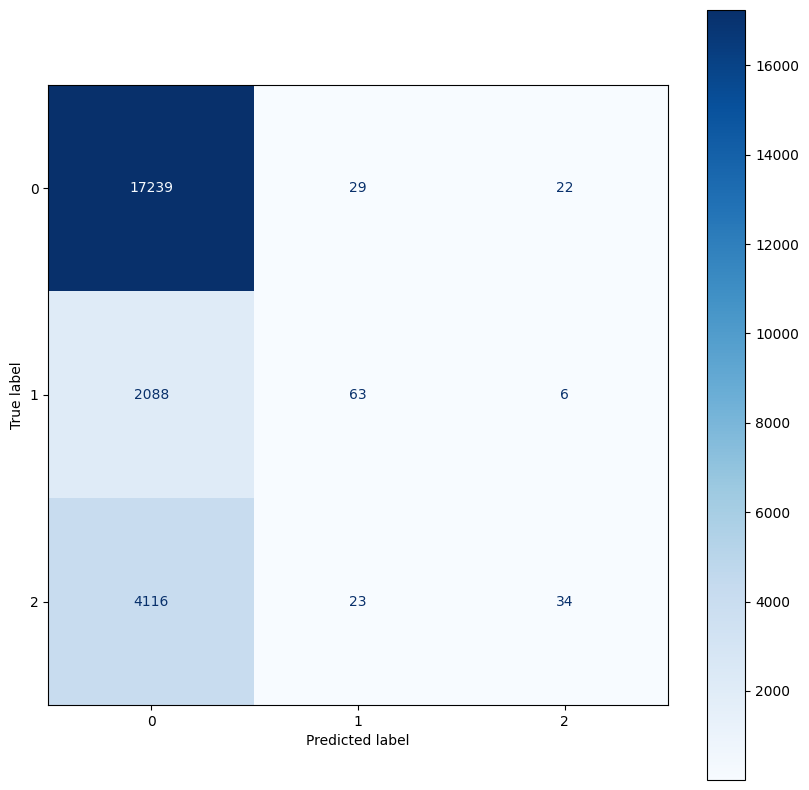

In [59]:
# Lancio funzione che stampa i risultati con i parametri migliori con GridSearchCV
model_fn(clf_rf, X_train, Y_train)

Best parameters found  :
 {'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}


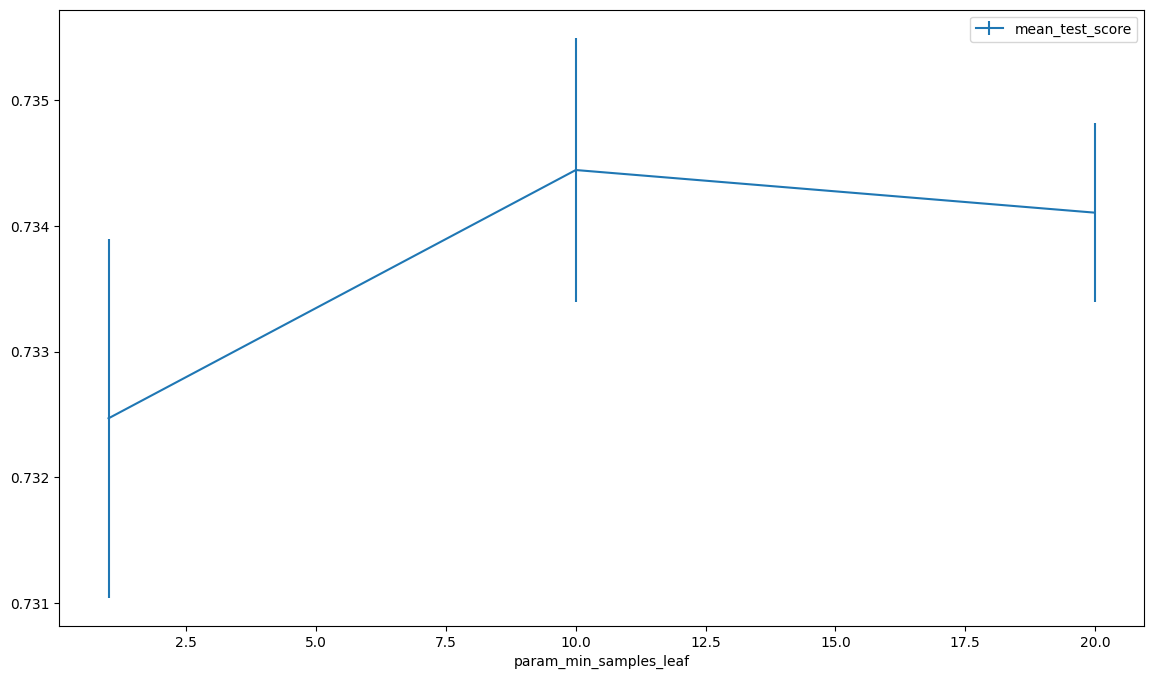

In [63]:
# Stampo i risultati al variare della 'param_max_depth'
best_parameter(clf_rf ,'param_min_samples_leaf')

## BayesSearchCV


In [74]:

clf = BayesSearchCV(
    estimator= rf,
    search_spaces= parameter_space,
    n_iter=20,
    optimizer_kwargs= {'base_estimator': 'RF'},
    n_jobs=5,
    verbose=0,
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    random_state=1
    
)

c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 20, 500] before, using random point [None, 10, 200]
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 1, 500] before, using random point ['sqrt', 1, 200]
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 1, 500] before, using random point ['sqrt', 1, 500]
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 1, 500] before, using random point ['sqrt', 10, 500]
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['sqrt', 20, 500] before, using ran

Training Accuracy: 0.7365
Test Accuracy: 0.7336
Precision: 0.5801
Recall: 0.3503
F1 Score: 0.318 

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     17290
           1       0.57      0.04      0.08      2157
           2       0.44      0.02      0.03      4173

    accuracy                           0.73     23620
   macro avg       0.58      0.35      0.32     23620
weighted avg       0.67      0.73      0.63     23620



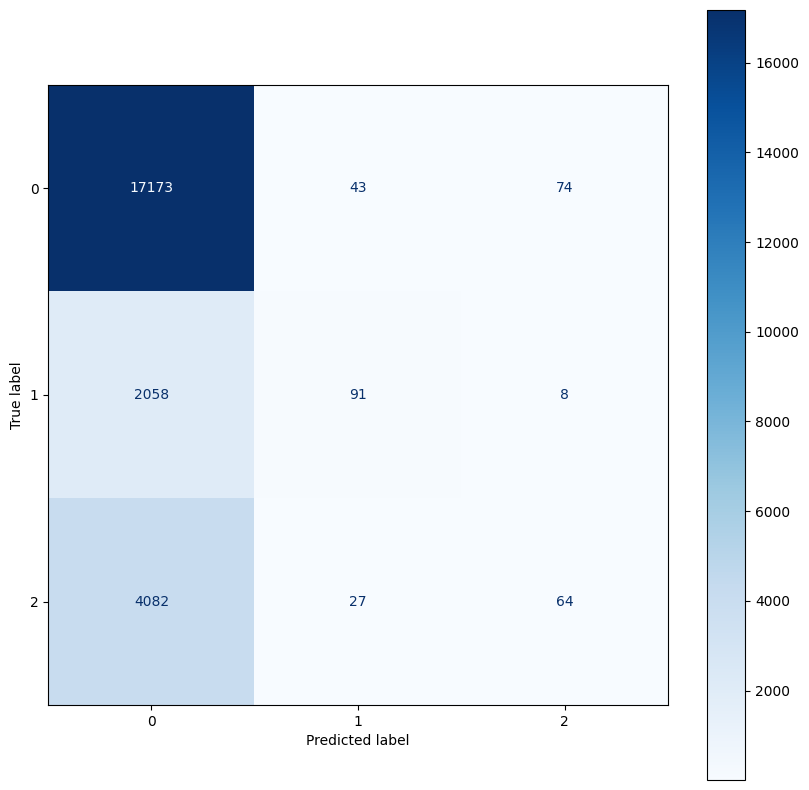

In [75]:
# Lancio funzione che stampa i risultati con i parametri migliori con BayesSearchCV
model_fn(clf, X_train, Y_train)

Best parameters found  :
 OrderedDict([('max_features', None), ('min_samples_leaf', 20), ('n_estimators', 500)])


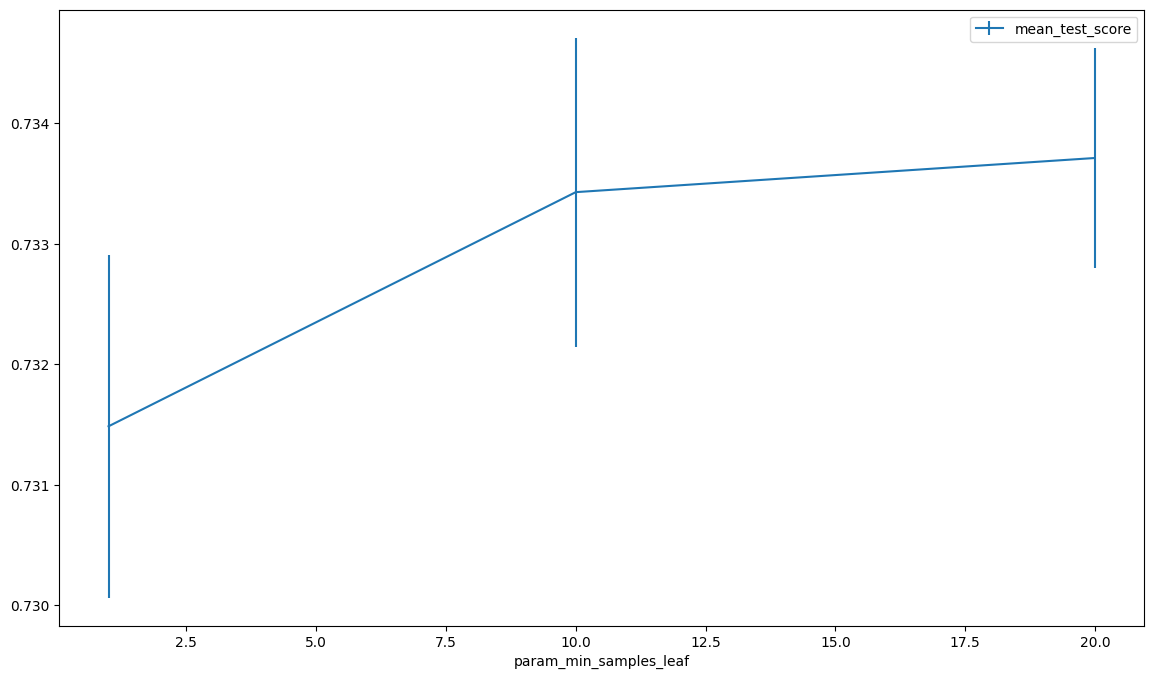

In [76]:
# # Stampo i risultati al variare della 'param_min_samples_leaf'
best_parameter(clf ,'param_min_samples_leaf')

# HyperParameter tuning per DecisionTreeClassifier

In [78]:
parameter_space_dt = {
    'max_features': ['sqrt', 'log2', None], 
    #'max_depth': [2,5,10,20], 
    'criterion' : ['gini' , 'entropy'],
    'min_samples_leaf': [1,5,10,20]
}

## GridSearch per DecisionTree

In [108]:
clf_dt = GridSearchCV(dt, parameter_space_dt, cv=5)

Training Accuracy: 0.7352
Test Accuracy: 0.732
Precision: 0.5425
Recall: 0.3431
F1 Score: 0.3043 

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     17290
           1       0.49      0.02      0.04      2157
           2       0.40      0.01      0.03      4173

    accuracy                           0.73     23620
   macro avg       0.54      0.34      0.30     23620
weighted avg       0.65      0.73      0.63     23620



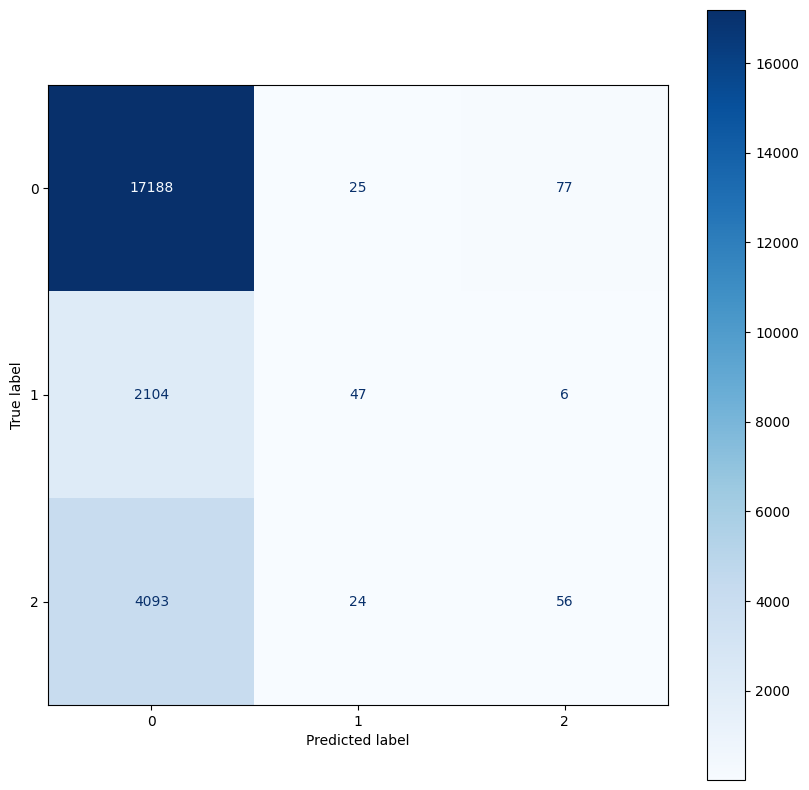

In [109]:
model_fn(clf_dt, X_train, Y_train)

Best parameters found  :
 {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20}


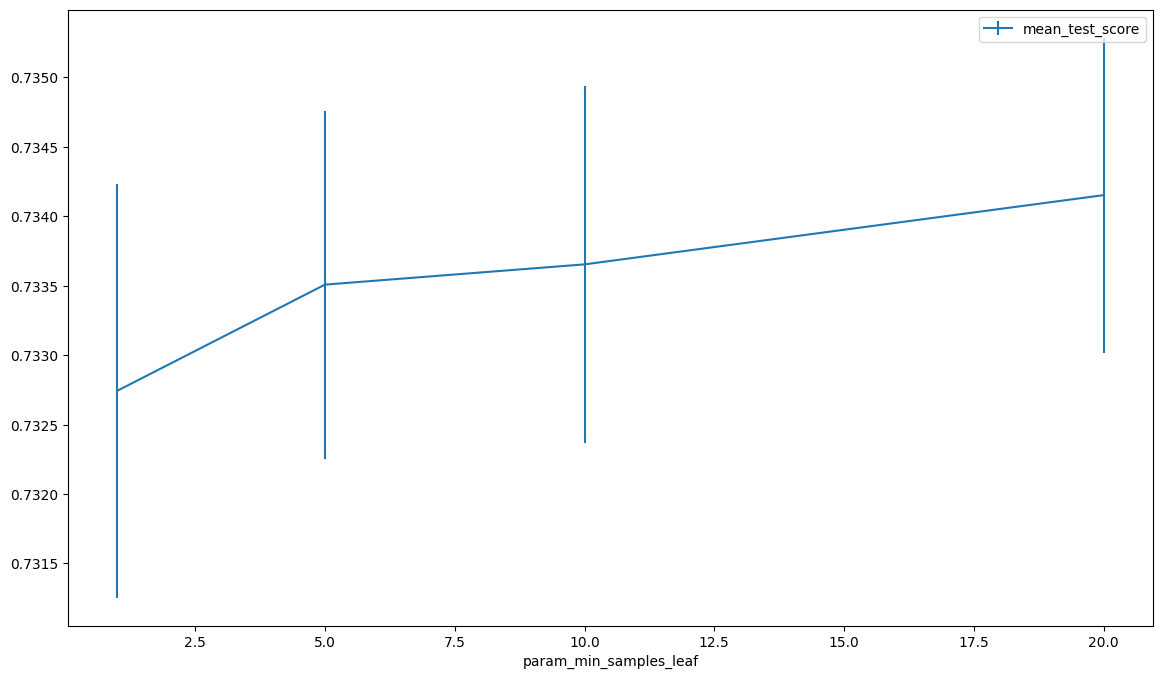

In [110]:
# # Stampo i risultati al variare della 'param_min_samples_leaf'
best_parameter(clf_dt ,'param_min_samples_leaf')

# BayesSearchCV per DecisionTree

In [79]:
clf_dt = BayesSearchCV(
    estimator= dt,
    search_spaces= parameter_space_dt,
    n_iter=20,
    n_jobs=5,
    verbose=0,
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    random_state=1
    
)

c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 'log2', 20] before, using random point ['entropy', 'log2', 5]
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 'log2', 10] before, using random point ['gini', 'log2', 20]
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 'log2', 20] before, using random point ['entropy', None, 1]
  warnings.warn(


Training Accuracy: 0.7351
Test Accuracy: 0.7331
Precision: 0.569
Recall: 0.3458
F1 Score: 0.3094 

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     17290
           1       0.52      0.03      0.05      2157
           2       0.45      0.02      0.03      4173

    accuracy                           0.73     23620
   macro avg       0.57      0.35      0.31     23620
weighted avg       0.67      0.73      0.63     23620



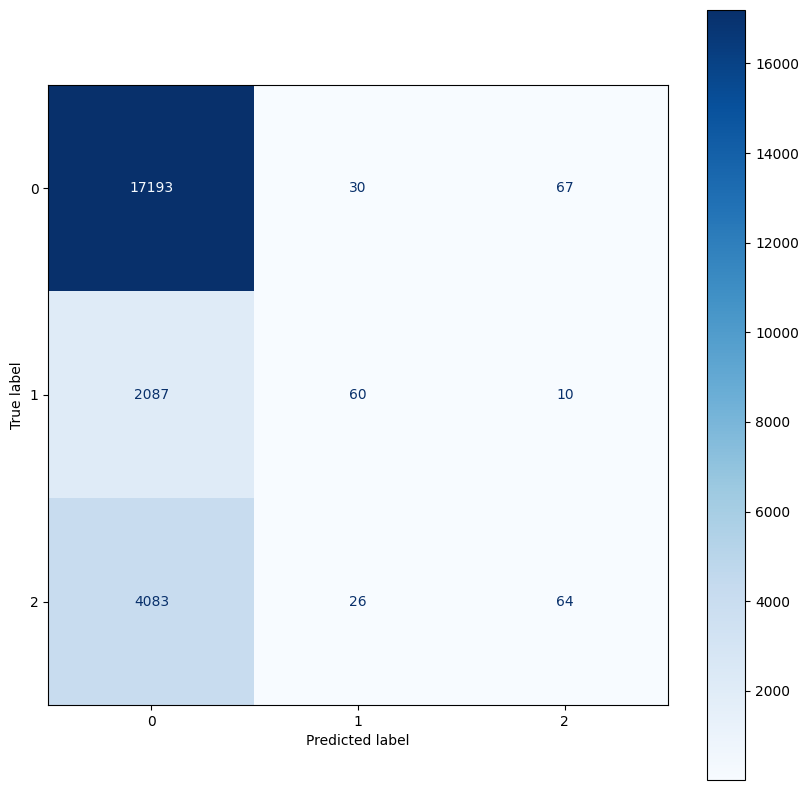

In [80]:
# Lancio funzione che stampa i risultati con i parametri migliori con BayesSearchCV
model_fn(clf_dt, X_train, Y_train)

Best parameters found  :
 OrderedDict([('criterion', 'gini'), ('max_features', 'log2'), ('min_samples_leaf', 20)])


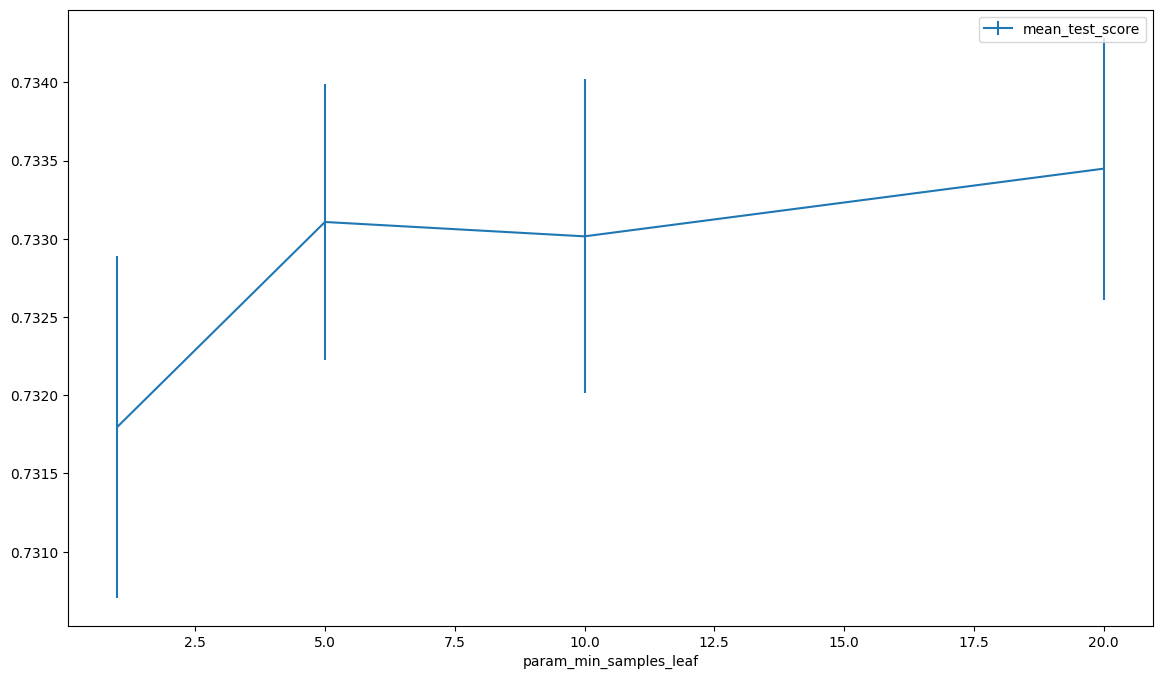

In [81]:
# # Stampo i risultati al variare della 'param_min_samples_leaf'
best_parameter(clf_dt ,'param_min_samples_leaf')

# SMOTE

In [ ]:
# creo un'istanza della classe "SMOTE()" 
oversample = SMOTE()
# utilizzo il metodo fit_resample() sull'oggetto oversample e passo X_train e Y_train come input.
# "fit_resample()" aumenta la quantità di dati delle classi minoritarie. 
# Restituisce la matrice di dati ridotta X_train_smote e il vettore di etichette ridotto Y_train_smote come output.
X_train_smote, Y_train_smote = oversample.fit_resample(X_train, Y_train)
# creo un grafico a torta che rappresenta la distribuzione delle nuove occorrenze dei valori nella variabile "Y_train_smote" 
values = Y_train_smote.value_counts()
names = values.index
fig = px.pie(names=names, values=values, hole=0.2)
fig.update_layout({
    'title' : {
       'text': 'Over-sampling',
     'x':0.5
    }    
})
fig.show()

## Cross-Validation

In [83]:

# utilizzo un ciclo "for" per eseguire la validazione incrociata a 5 riprese sui dati "X_train_smote" e "Y_train_smote".
for model in models:
    # La funzione cross_val_score() viene utilizzata per calcolare le prestazioni del modello sui dati di input
    # utilizzando la validazione incrociata a 5 riprese, cioè il modello viene addestrato su 4/5 dei dati e testato su 1/5 dei dati,
    # questo processo viene ripetuto 5 volte utilizzando un diverso insieme di dati per il test ogni volta.
    scores = cross_val_score(model, X_train_smote, Y_train_smote, cv=5)
    # Stampo i risultati delle valutazioni per ogni modello, mostrando i punteggi di validazione incrociata...
    print("Cross-validation scores for {}: {}".format(model.__class__.__name__,scores))
    # ...e la media dei punteggi per ogni modello.
    print("Mean cross-validation score for {}: {:.2f}\n".format(model.__class__.__name__,scores.mean()))

Cross-validation scores for DecisionTreeClassifier: [0.51113889 0.53207039 0.54423644 0.54051802 0.53776125]
Mean cross-validation score for DecisionTreeClassifier: 0.53

Cross-validation scores for GaussianNB: [0.35804725 0.35628426 0.35738556 0.35632773 0.35648801]
Mean cross-validation score for GaussianNB: 0.36

Cross-validation scores for RandomForestClassifier: [0.5119082  0.53463474 0.54708937 0.54378767 0.54090268]
Mean cross-validation score for RandomForestClassifier: 0.54

Cross-validation scores for LogisticRegression: [0.45270379 0.4513575  0.45755866 0.46053981 0.45618028]
Mean cross-validation score for LogisticRegression: 0.46

Cross-validation scores for XGBClassifier: [0.49998397 0.52694169 0.53567765 0.53538915 0.53285678]
Mean cross-validation score for XGBClassifier: 0.53



## Modelli

Training Accuracy: 0.5514
Test Accuracy: 0.47
Precision: 0.408
Recall: 0.4594
F1 Score: 0.3858 

              precision    recall  f1-score   support

           0       0.82      0.48      0.61     17290
           1       0.17      0.49      0.25      2157
           2       0.24      0.41      0.30      4173

    accuracy                           0.47     23620
   macro avg       0.41      0.46      0.39     23620
weighted avg       0.66      0.47      0.52     23620



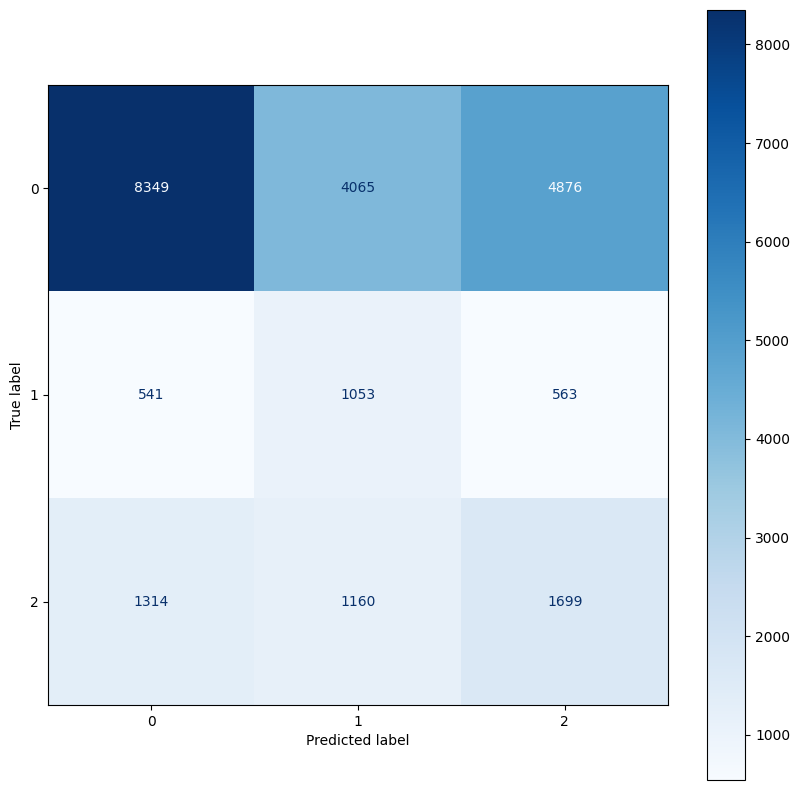

In [84]:
model_fn(rf, X_train_smote, Y_train_smote)

Training Accuracy: 0.5514
Test Accuracy: 0.47
Precision: 0.4073
Recall: 0.4585
F1 Score: 0.3853 

              precision    recall  f1-score   support

           0       0.82      0.48      0.61     17290
           1       0.17      0.49      0.25      2157
           2       0.24      0.40      0.30      4173

    accuracy                           0.47     23620
   macro avg       0.41      0.46      0.39     23620
weighted avg       0.66      0.47      0.52     23620



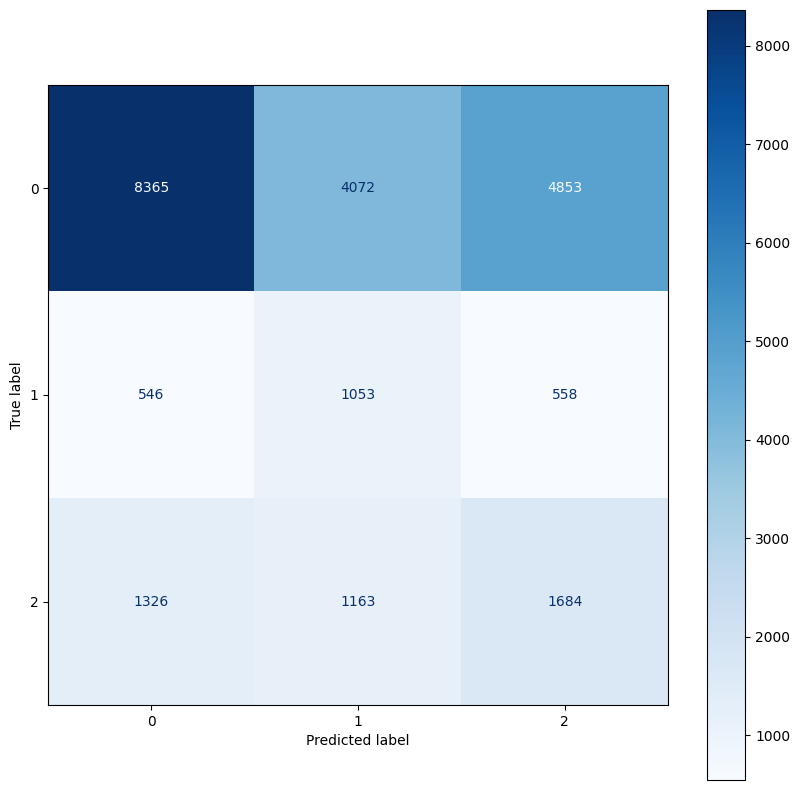

In [85]:
model_fn(dt, X_train_smote, Y_train_smote)

Training Accuracy: 0.4559
Test Accuracy: 0.4623
Precision: 0.4032
Recall: 0.4525
F1 Score: 0.3777 

              precision    recall  f1-score   support

           0       0.81      0.48      0.60     17290
           1       0.16      0.51      0.24      2157
           2       0.24      0.37      0.29      4173

    accuracy                           0.46     23620
   macro avg       0.40      0.45      0.38     23620
weighted avg       0.65      0.46      0.51     23620



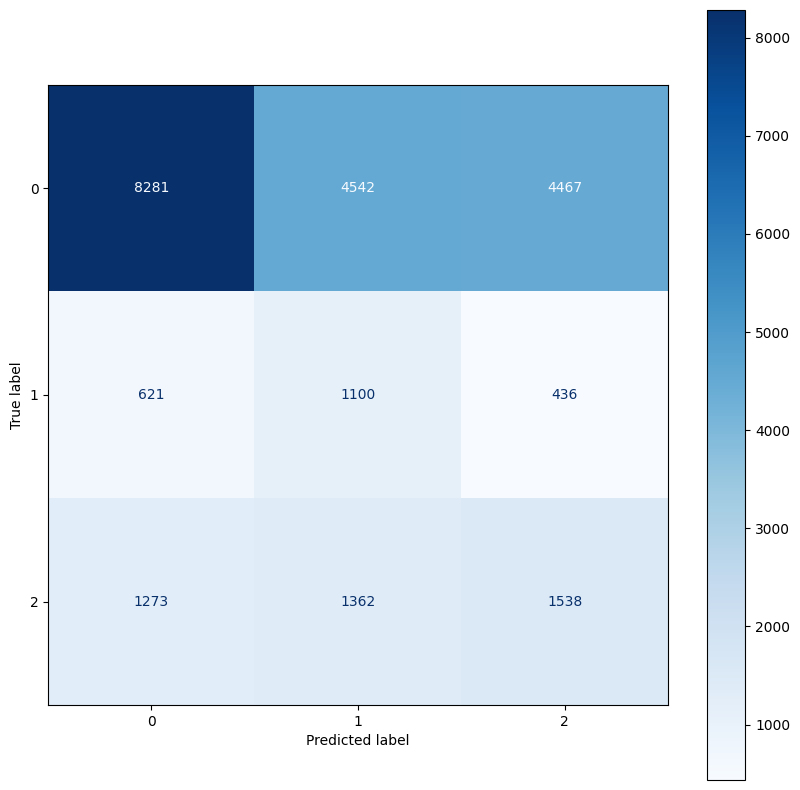

In [86]:
model_fn(lr, X_train_smote, Y_train_smote)

Training Accuracy: 0.3572
Test Accuracy: 0.1523
Precision: 0.4214
Recall: 0.3538
F1 Score: 0.1213 

              precision    recall  f1-score   support

           0       0.84      0.08      0.15     17290
           1       0.10      0.96      0.17      2157
           2       0.33      0.02      0.04      4173

    accuracy                           0.15     23620
   macro avg       0.42      0.35      0.12     23620
weighted avg       0.68      0.15      0.13     23620



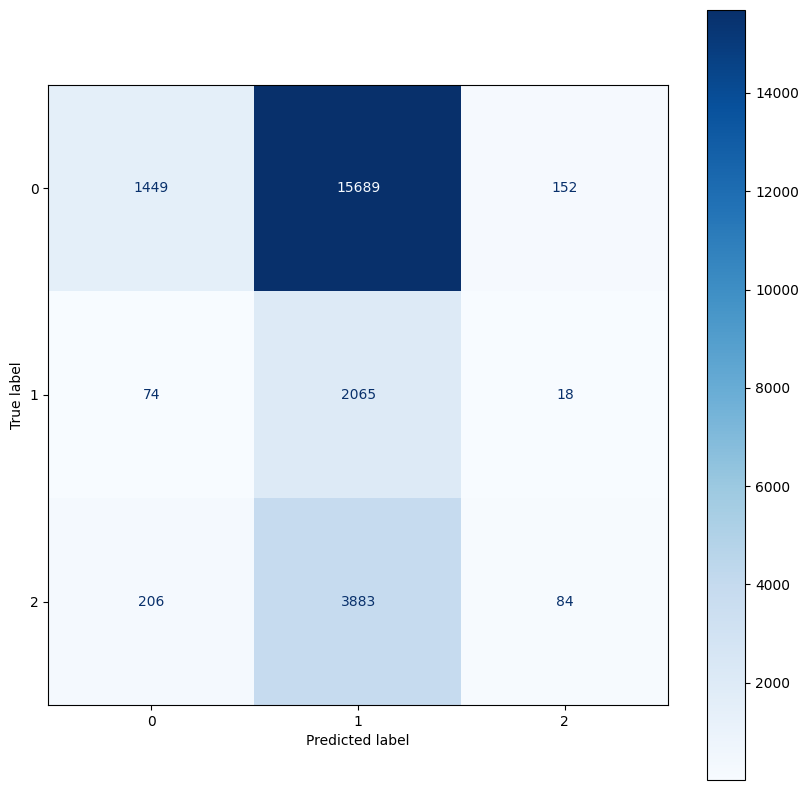

In [87]:
model_fn(gnb, X_train_smote, Y_train_smote)

Training Accuracy: 0.5351
Test Accuracy: 0.4815
Precision: 0.4118
Recall: 0.4669
F1 Score: 0.3928 

              precision    recall  f1-score   support

           0       0.82      0.50      0.62     17290
           1       0.17      0.51      0.26      2157
           2       0.24      0.39      0.30      4173

    accuracy                           0.48     23620
   macro avg       0.41      0.47      0.39     23620
weighted avg       0.66      0.48      0.53     23620



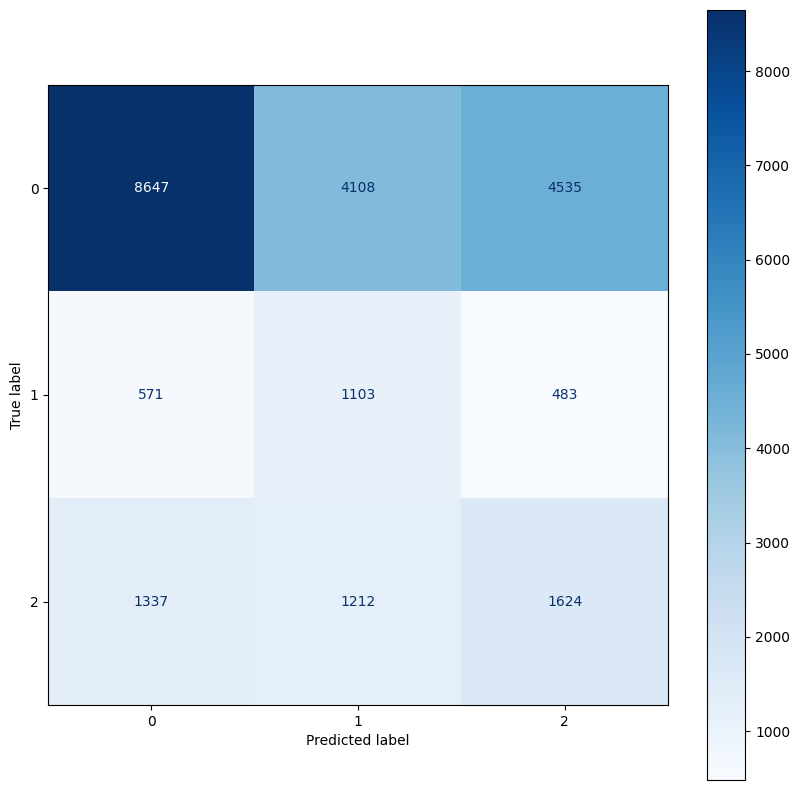

In [88]:
model_fn(xgb , X_train_smote, Y_train_smote)

# Near Miss-1

In [89]:
# creo un'istanza della classe "NearMiss()" e imposto la strategia di campionamento su "not minority"
# che indica di non ridurre le classi minoritarie. Utilizzo la prima versione dell'algoritmo.
nm1 = NearMiss(sampling_strategy='not minority', version=1)
# utilizzo il metodo fit_resample() sull'oggetto nm1 e passo X_train e Y_train come input.
# "fit_resample()" riduce la quantità di dati delle classi maggioritarie. 
# Restituisce la matrice di dati ridotta X_train_nm1 e il vettore di etichette ridotto Y_train_nm1 come output.
X_train_nm1, Y_train_nm1 = nm1.fit_resample(X_train, Y_train)
# creo un grafico a torta che rappresenta la distribuzione delle nuove occorrenze dei valori nella variabile "Y_train_nm1" 
#values = Y_train_nm1.value_counts()
#names = values.index
#fig = px.pie(names=names, values=values, hole=0.2)
#fig.update_layout({
#    'title' : {
#        'text': 'Under-sampling',
#        'x':0.5
 #   }    
#})
#fig.show()

## Cross-Validation 

In [90]:

for model in models:
    # La funzione cross_val_score() viene utilizzata per calcolare le prestazioni del modello sui dati di input
    # utilizzando la validazione incrociata a 5 riprese, cioè il modello viene addestrato su 4/5 dei dati e testato su 1/5 dei dati,
    # questo processo viene ripetuto 5 volte utilizzando un diverso insieme di dati per il test ogni volta.
    scores = cross_val_score(model, X_train_nm1, Y_train_nm1, cv=5)
    # Stampo i risultati delle valutazioni per ogni modello, mostrando i punteggi di validazione incrociata...
    print("Cross-validation scores for {}: {}".format(model.__class__.__name__,scores))
    # ...e la media dei punteggi per ogni modello.
    print("Mean cross-validation score for {}: {:.2f}\n".format(model.__class__.__name__,scores.mean()))

Cross-validation scores for DecisionTreeClassifier: [0.48544453 0.49068975 0.47743966 0.48321091 0.48137461]
Mean cross-validation score for DecisionTreeClassifier: 0.48

Cross-validation scores for GaussianNB: [0.41620771 0.41909258 0.34653725 0.40897167 0.34889822]
Mean cross-validation score for GaussianNB: 0.39

Cross-validation scores for RandomForestClassifier: [0.48937844 0.49226331 0.48373557 0.48373557 0.48740818]
Mean cross-validation score for RandomForestClassifier: 0.49

Cross-validation scores for LogisticRegression: [0.4489903  0.45476003 0.4412382  0.44779643 0.45697796]
Mean cross-validation score for LogisticRegression: 0.45

Cross-validation scores for XGBClassifier: [0.49278783 0.49750852 0.48557188 0.4866212  0.4884575 ]
Mean cross-validation score for XGBClassifier: 0.49



## Modelli

Training Accuracy: 0.5279
Test Accuracy: 0.3666
Precision: 0.3815
Recall: 0.3896
F1 Score: 0.3135 

              precision    recall  f1-score   support

           0       0.81      0.36      0.50     17290
           1       0.10      0.49      0.17      2157
           2       0.23      0.32      0.27      4173

    accuracy                           0.37     23620
   macro avg       0.38      0.39      0.31     23620
weighted avg       0.64      0.37      0.43     23620



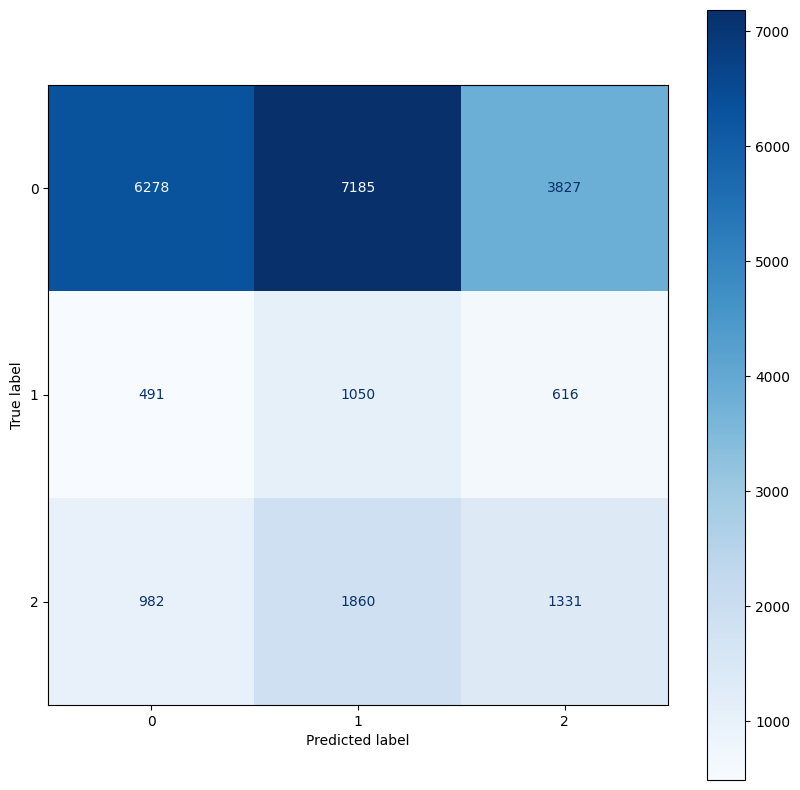

In [91]:
# è possibile scegliere un input tra quelli disponibili: 
# rf (Random Forest)
# dt (Decision Tree)
# lr (Logistic Regression)
# gnb (Gaussian Naive Bayes)
# xgb (XGBoost)

model_fn(rf, X_train_nm1, Y_train_nm1)

Training Accuracy: 0.5281
Test Accuracy: 0.3771
Precision: 0.3814
Recall: 0.3925
F1 Score: 0.3189 

              precision    recall  f1-score   support

           0       0.81      0.38      0.52     17290
           1       0.11      0.48      0.17      2157
           2       0.23      0.32      0.27      4173

    accuracy                           0.38     23620
   macro avg       0.38      0.39      0.32     23620
weighted avg       0.64      0.38      0.44     23620



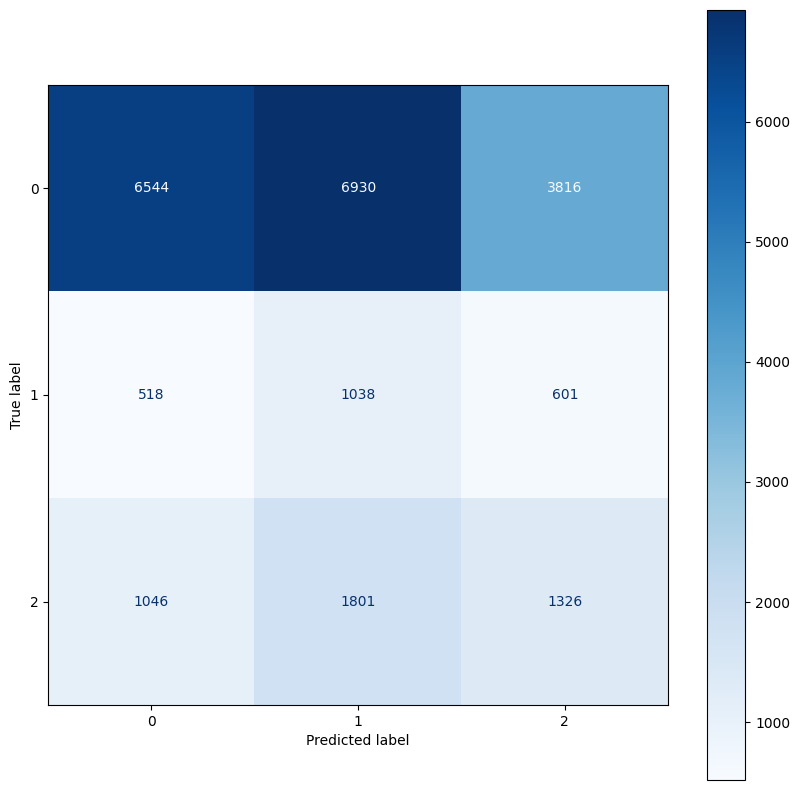

In [92]:
model_fn(dt, X_train_nm1, Y_train_nm1)

Training Accuracy: 0.4544
Test Accuracy: 0.4395
Precision: 0.3921
Recall: 0.4226
F1 Score: 0.3562 

              precision    recall  f1-score   support

           0       0.81      0.46      0.59     17290
           1       0.13      0.46      0.20      2157
           2       0.23      0.34      0.28      4173

    accuracy                           0.44     23620
   macro avg       0.39      0.42      0.36     23620
weighted avg       0.65      0.44      0.50     23620



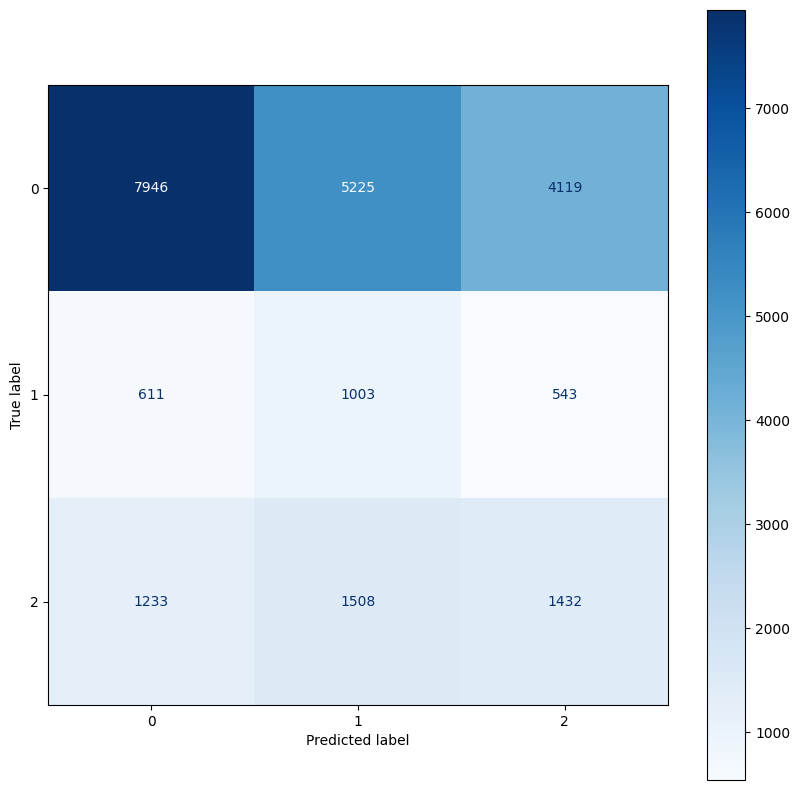

In [93]:
model_fn(lr, X_train_nm1, Y_train_nm1)

Training Accuracy: 0.4165
Test Accuracy: 0.5282
Precision: 0.3684
Recall: 0.3886
F1 Score: 0.3506 

              precision    recall  f1-score   support

           0       0.79      0.59      0.67     17290
           1       0.08      0.04      0.06      2157
           2       0.23      0.54      0.32      4173

    accuracy                           0.53     23620
   macro avg       0.37      0.39      0.35     23620
weighted avg       0.63      0.53      0.56     23620



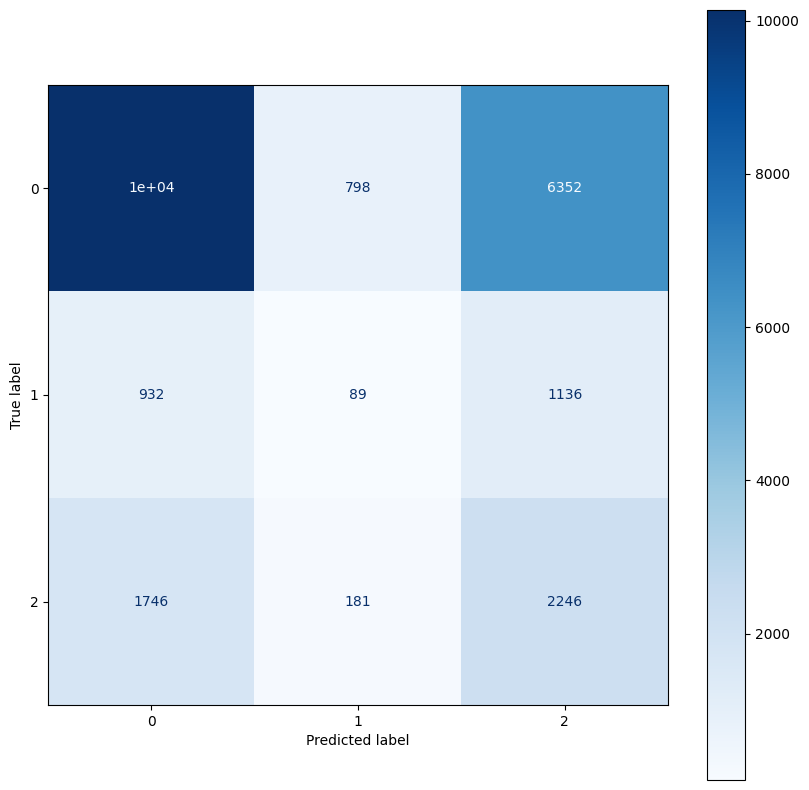

In [94]:
model_fn(gnb, X_train_nm1, Y_train_nm1)

Training Accuracy: 0.5244
Test Accuracy: 0.3725
Precision: 0.3853
Recall: 0.3985
F1 Score: 0.32 

              precision    recall  f1-score   support

           0       0.82      0.36      0.50     17290
           1       0.11      0.47      0.18      2157
           2       0.23      0.36      0.28      4173

    accuracy                           0.37     23620
   macro avg       0.39      0.40      0.32     23620
weighted avg       0.65      0.37      0.43     23620



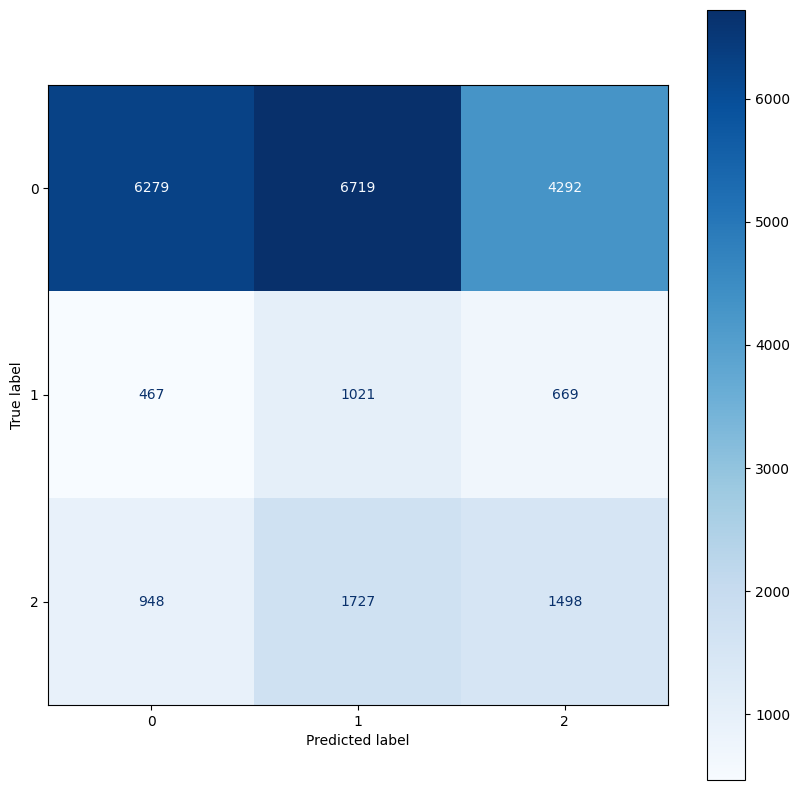

In [95]:
model_fn(xgb, X_train_nm1, Y_train_nm1)

# Neural Network Classifier

In [96]:
# Prova su un solo layer intermedio 
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,),(20,),(50,), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


In [97]:
clf_nn = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)

Training Accuracy: 0.7368
Test Accuracy: 0.7339
Precision: 0.5895
Recall: 0.3485
F1 Score: 0.3135 

              precision    recall  f1-score   support

           0       0.74      1.00      0.85     17290
           1       0.57      0.04      0.08      2157
           2       0.47      0.01      0.02      4173

    accuracy                           0.73     23620
   macro avg       0.59      0.35      0.31     23620
weighted avg       0.67      0.73      0.63     23620



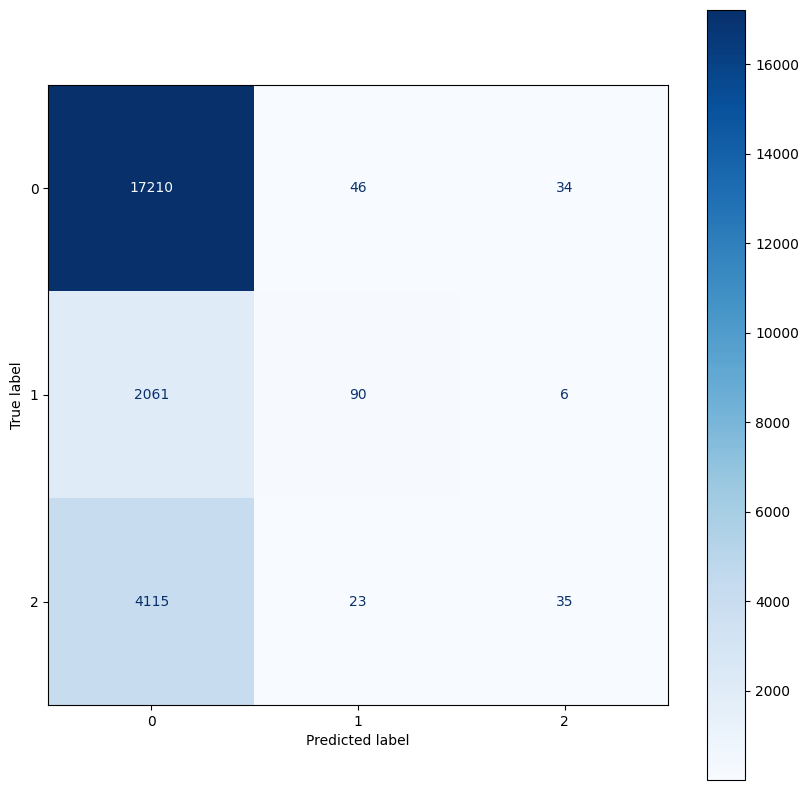

In [98]:

# Lancio funzione che stampa i risultati con i parametri migliori con GridSearchCV
model_fn(clf_nn, X_train, Y_train)

Best parameters found  :
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}


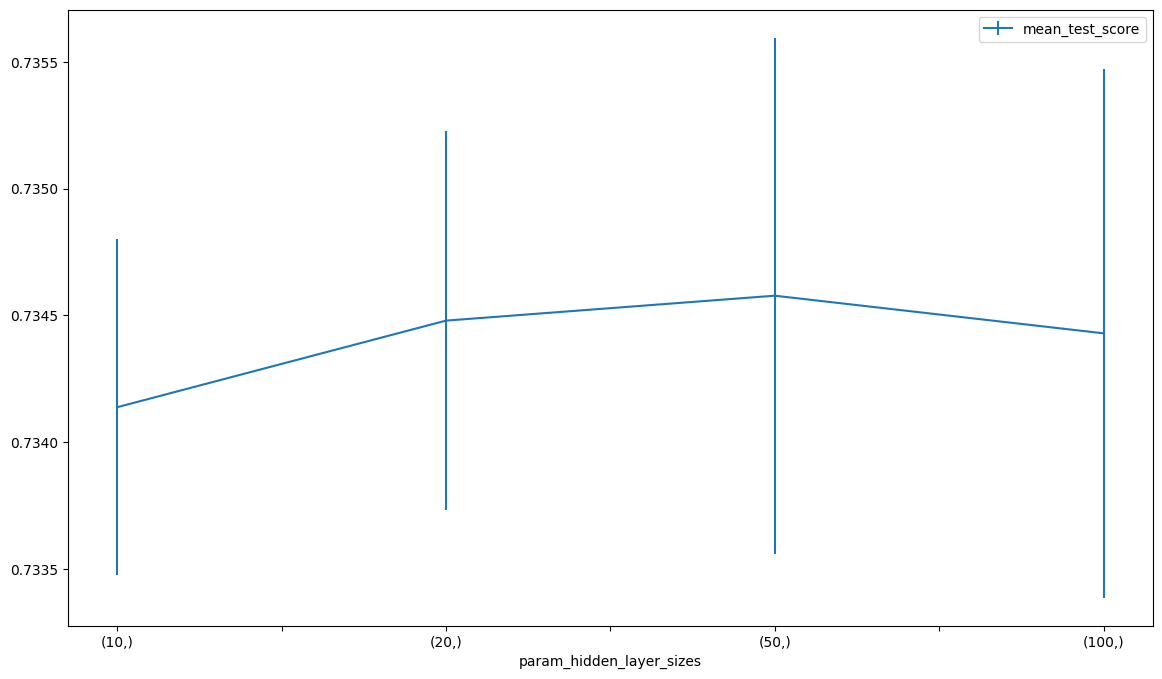

In [99]:
# Stampo i risultati al variare della 'param_hidden_layer_sizes'
best_parameter(clf_nn ,'param_hidden_layer_sizes')

In [ ]:
# Stampa di tutti i valori risultanti dalle combinazioni di tutti i parametri
means = clf_nn.cv_results_['mean_test_score']
stds = clf_nn.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [100]:
# Prova con due layer intermedi
mlp_gs2 = MLPClassifier(max_iter=100)
parameter_space2 = {
    'hidden_layer_sizes': [(10,10),(20,20),(50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf_nn2 = GridSearchCV(mlp_gs2, parameter_space2, n_jobs=-1, cv=5)


In [101]:
clf_nn2 = GridSearchCV(mlp_gs2, parameter_space2, n_jobs=-1, cv=5)

Training Accuracy: 0.7372
Test Accuracy: 0.7341
Precision: 0.5858
Recall: 0.3502
F1 Score: 0.3171 

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     17290
           1       0.55      0.04      0.08      2157
           2       0.47      0.01      0.02      4173

    accuracy                           0.73     23620
   macro avg       0.59      0.35      0.32     23620
weighted avg       0.67      0.73      0.63     23620



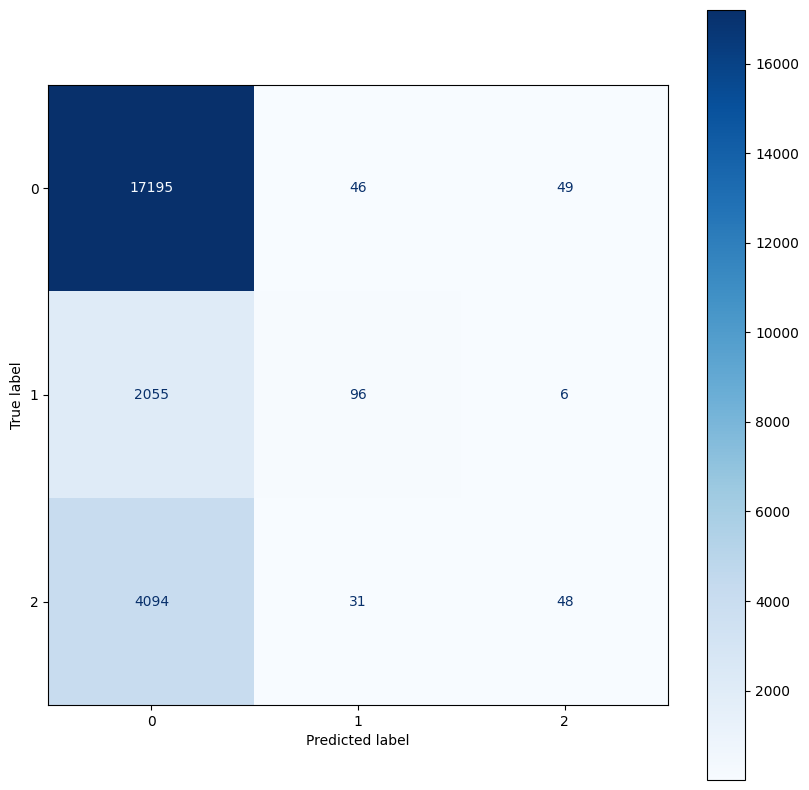

In [102]:
# Lancio funzione che stampa i risultati con i parametri migliori con GridSearchCV
model_fn(clf_nn2, X_train, Y_train)

Best parameters found  :
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


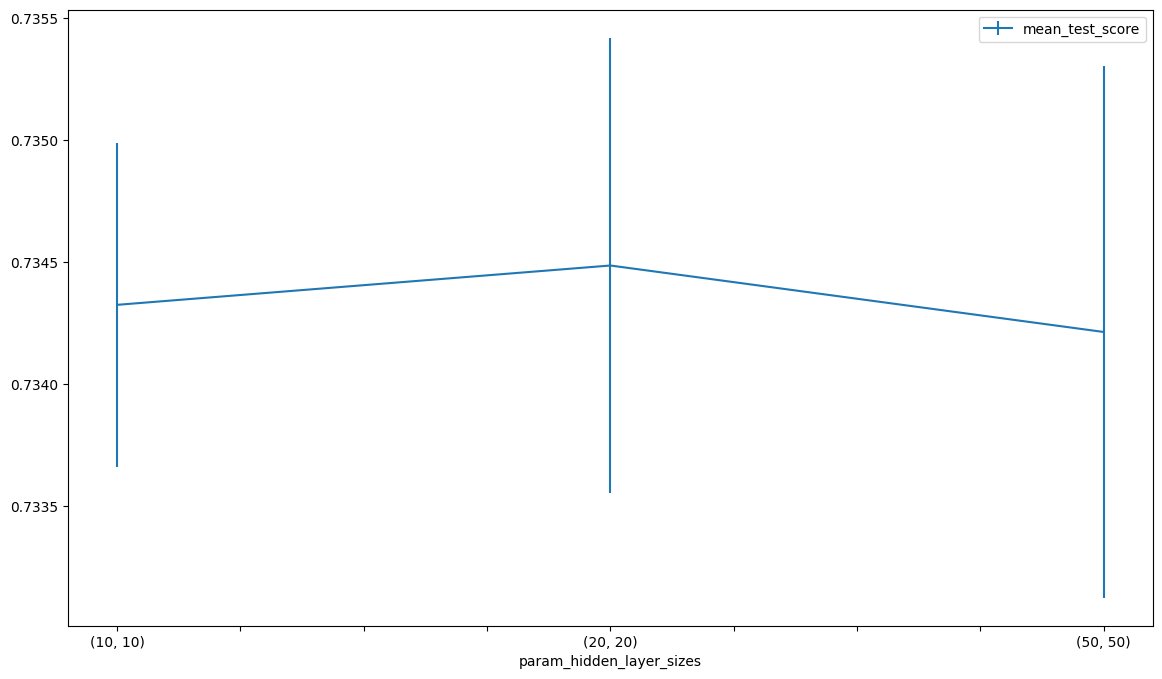

In [103]:
# Stampo i risultati al variare della 'param_hidden_layer_sizes'
best_parameter(clf_nn2 ,'param_hidden_layer_sizes')

In [ ]:
# Stampa di tutti i valori risultanti dalle combinazioni di tutti i parametri
means2 = clf_nn2.cv_results_['mean_test_score']
stds2 = clf_nn2.cv_results_['std_test_score']
for mean, std, params in zip(means2, stds2, clf2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [104]:
#Prova con tre layer intermedi
mlp_gs3 = MLPClassifier(max_iter=100)
parameter_space3 = {
    'hidden_layer_sizes': [(10,10,10),(20,20,20),(20,50,20)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


In [105]:
clf_nn3 = GridSearchCV(mlp_gs3, parameter_space3, n_jobs=-1, cv=5)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training Accuracy: 0.7361
Test Accuracy: 0.7341
Precision: 0.5935
Recall: 0.3502
F1 Score: 0.3174 

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     17290
           1       0.59      0.04      0.08      2157
           2       0.45      0.01      0.02      4173

    accuracy                           0.73     23620
   macro avg       0.59      0.35      0.32     23620
weighted avg       0.67      0.73      0.63     23620



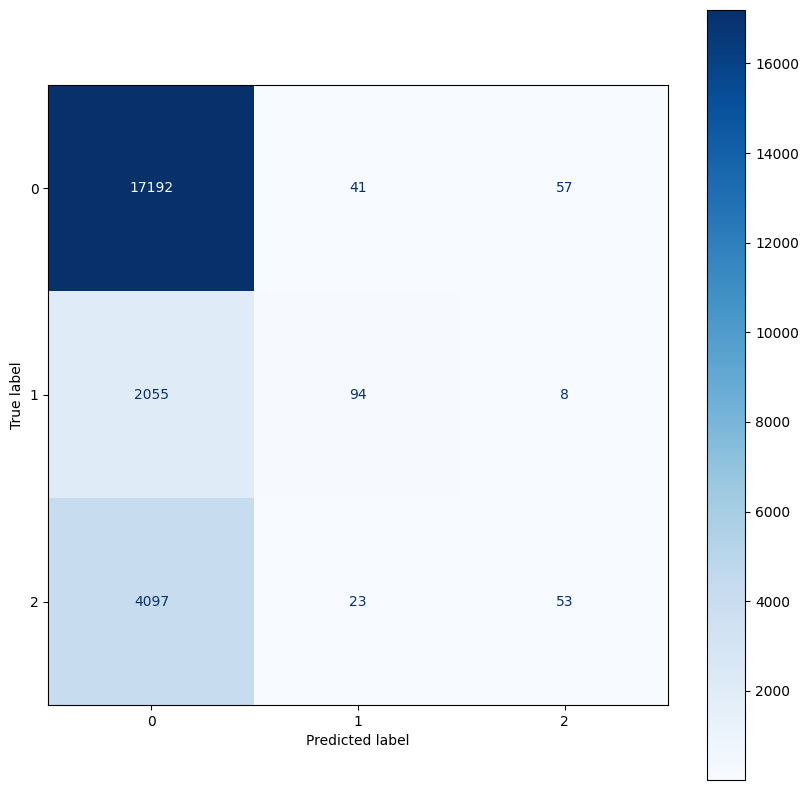

In [106]:
# Lancio funzione che stampa i risultati con i parametri migliori con GridSearchCV
model_fn(clf_nn3, X_train, Y_train)

Best parameters found  :
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (20, 20, 20), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


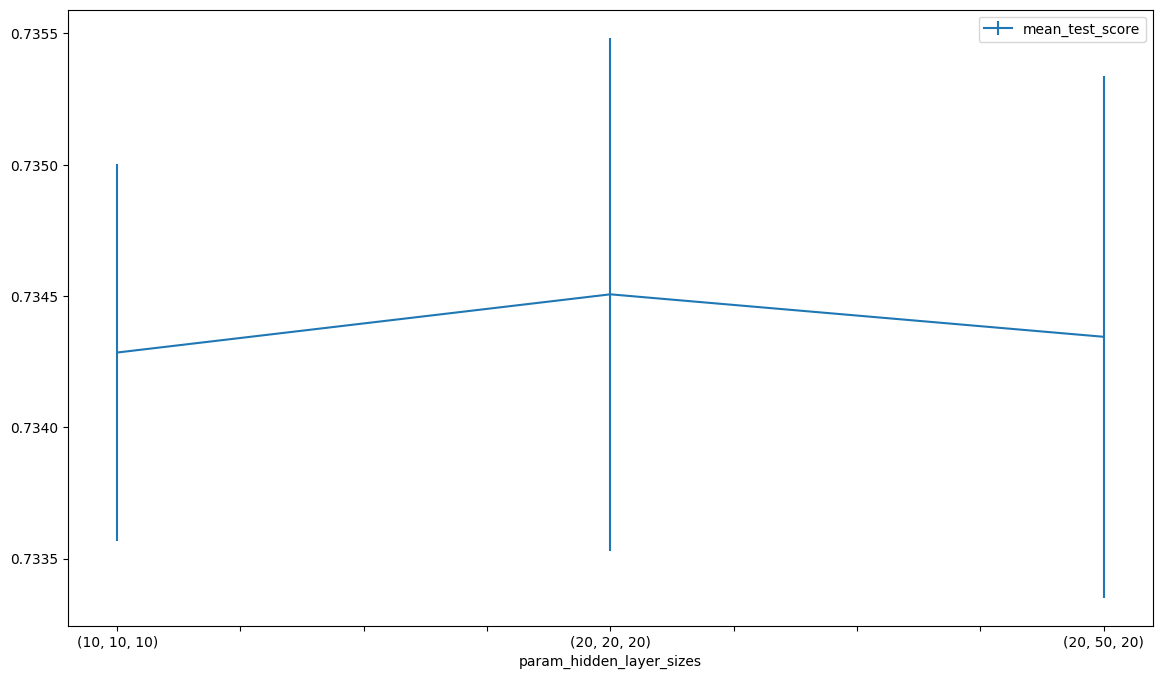

In [107]:
# Stampo i risultati al variare della 'param_hidden_layer_sizes'
best_parameter(clf_nn3 ,'param_hidden_layer_sizes')

In [ ]:
# Stampa di tutti i valori risultanti dalle combinazioni di tutti i parametri
means3 = clf3.cv_results_['mean_test_score']
stds3 = clf3.cv_results_['std_test_score']
for mean, std, params in zip(means3, stds3, clf3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))